# General Visualization (new dataset)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
%matplotlib inline

In [3]:
#load in h5 file and indices files
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_2files.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_2files.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_2files.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_2files.txt"

To access any part of the h5 dataset, <br> 
1) read the h5 file, 2) create a memory mapping to it <br>

looking into the h5 file... <br> 
x_data = [charge, time, pmt_position_x, pmt_position_y, pmt_position_z, pmt_direction_x, pmt_direction_y, pmt_direction_z] <br>
'labels' == particle id, ... , 
'event_data' == x_data

In [4]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_event_data = file['event_data']
    h5_nhits = file['nhits']
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    
    event_mem_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_mem_data.shape))
    print("{} events. Up to 300 hits per event. 8 features per hit per event".format(h5_event_data.shape[0]))
    nhits = np.array(h5_nhits)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (1764, 300, 8)
1764 events. Up to 300 hits per event. 8 features per hit per event


In [5]:
def load_indicies(indicies_file):
        with open(indicies_file, 'r') as f:
            lines = f.readlines()
        # indicies = [int(l.strip()) for l in lines if not l.isspace()]
        indicies = [int(l.strip()) for l in lines]
        return indicies

Verify the number of hits per event

In [8]:
non_zero = [np.count_nonzero(event_mem_data[i,:,0]) for i in range(0, event_mem_data.shape[0])]
non_zero  = np.array(non_zero)
# nhits should be equal to non_zero

print(non_zero[:25])
print(nhits[:25])

[162 130  63  51  80   8  97  67 146  78  54  73 139 104  11 120  68  36
  57 134  85  12 125  56  51]
[162 130  63  51  80   8  97  67 146  78  54  73 139 104  11 120  68  36
  57 134  85  12 125  56  51]


# Hits

Text(0, 0.5, 'Counts/bin (normalized)')

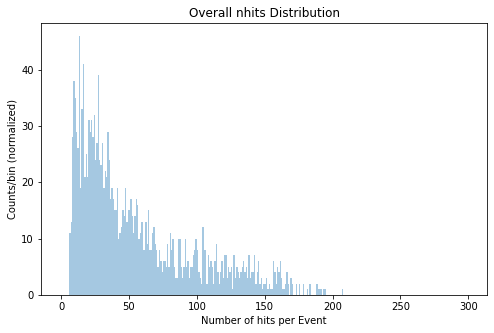

In [9]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(nhits, rug = False, kde=False, axlabel ="Number of hits per Event", bins = np.arange(0,300,1), norm_hist=False)
plt.title("Overall nhits Distribution")
plt.ylabel("Counts/bin (normalized)")

__Separate nhits array based on whether the event is electron or neutron__

get the index of the electron or neutron events. The way the files have been merged, they have not been shuffled yet - so there will be all events of one type, then all events of the next. <br>
label = 0 -> neutron <br>
label = 1 -> electron

In [10]:
neutron_hits = []
electron_hits = []
print(labels.shape)

for i in range(event_mem_data.shape[0]):
    if labels[i] == 0:
        neutron_hits.append(nhits[i])
    elif labels[i] == 1:
        electron_hits.append(nhits[i])

#convert to numpy arrays
neutron_hits = np.array(neutron_hits)
electron_hits = np.array(electron_hits)
        
print('nshape: {} \t eshape: {}'.format(neutron_hits.shape, electron_hits.shape))

(1764,)
nshape: (830,) 	 eshape: (934,)


In [11]:
print(stats.describe(neutron_hits))
print(stats.describe(electron_hits))

DescribeResult(nobs=830, minmax=(6, 82), mean=27.76987951807229, variance=246.78292760910955, skewness=0.8917683999992173, kurtosis=0.24835313720251317)
DescribeResult(nobs=934, minmax=(6, 207), mean=78.24625267665952, variance=2067.5620170250463, skewness=0.3551385526127215, kurtosis=-0.7774711234275329)


Get statistics on the neutron and electron event hit numbers. Visualize difference between hit distributions of neutron and electron events.

Text(0, 0.5, 'Counts/bin (normalized)')

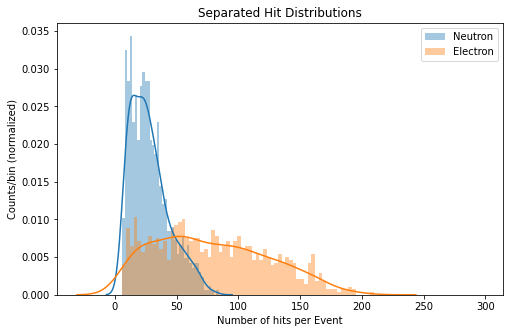

In [12]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(neutron_hits, rug = False, axlabel ="Number of hits per Event", bins = np.arange(0,300,2), label = "Neutron")
sns.distplot(electron_hits, rug = False, bins = np.arange(0,300,3), label = "Electron")
plt.legend()
plt.title("Separated Hit Distributions")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("hit_separation.png", bbox_inches='tight') 

Text(0, 0.5, 'Counts/bin (normalized)')

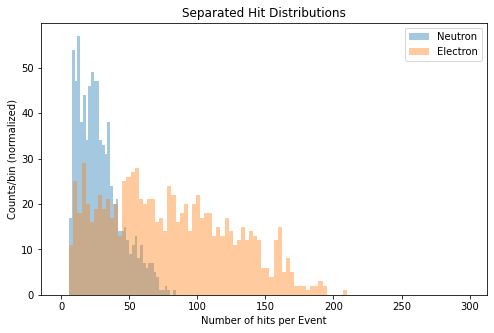

In [13]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(neutron_hits, rug = False, kde=False, axlabel ="Number of hits per Event", bins = np.arange(0,300,2), label = "Neutron")
sns.distplot(electron_hits, rug = False, kde=False, bins = np.arange(0,300,3), label = "Electron")
plt.legend()
plt.title("Separated Hit Distributions")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("hit_separation.png", bbox_inches='tight') 

# Charge

x_data = [charge, time, pmt_position_x, pmt_position_y, pmt_position_z,
		pmt_direction_x, pmt_direction_y, pmt_direction_z] <br>

'event_data' == x_data

In [14]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    h5_event_data = file['event_data']
    event_mem_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_mem_data.shape))
    
    h5_charges = event_mem_data[:, :, 0]
    print(h5_charges.shape)
    #nhits = np.array(h5_nhits)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (1764, 300, 8)
(1764, 300)


In [15]:
h5_charge_sums = h5_charges.sum(axis = 1)

Text(0, 0.5, 'Counts/bin (normalized)')

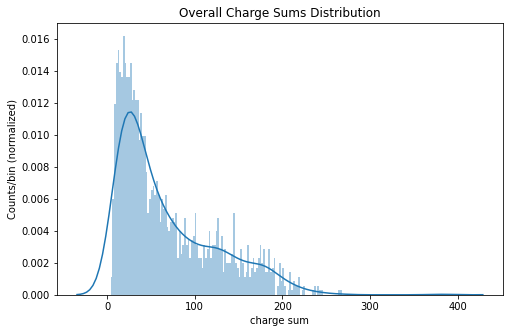

In [16]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(h5_charge_sums, rug = False, axlabel = "charge sum", bins = np.arange(0,300,2))
plt.title("Overall Charge Sums Distribution")
plt.ylabel("Counts/bin (normalized)")

In [17]:
neutron_charges = []
electron_charges = []

for i in range(0, event_mem_data.shape[0]):
    if labels[i] == 0:
        neutron_charges.append(h5_charges[i, :])
    elif labels[i] == 1:
        electron_charges.append(h5_charges[i, :])   

In [18]:
#### --------------------- by total charge ---------------------- #####
neutron_charge_sums = np.array(neutron_charges)
electron_charge_sums = np.array(electron_charges)

neutron_charge_sums = neutron_charge_sums.sum(axis = 1)
electron_charge_sums = electron_charge_sums.sum(axis = 1)

print(""), print(neutron_charge_sums.shape)
print(electron_charge_sums.shape), print("")

print("neutron charge sums ... \n {} {}".format(str(neutron_charge_sums[:10]), "...")), print(" ") 
print("electron charge sums ... \n {} {}".format(str(electron_charge_sums[:10]), "..."))


(830,)
(934,)

neutron charge sums ... 
 [18.20716  36.812374 27.834032 34.82169  28.005184  7.51101  23.346447
 23.112387 42.030945 41.391617] ...
 
electron charge sums ... 
 [188.47055  139.58286   66.948906  74.570175  97.27904    7.621234
 150.79431   76.23401  166.20804  101.06274 ] ...


In [19]:
print("neutron charge stats ... \n" + str(stats.describe(neutron_charge_sums))), print("")
print("electron charge stats ... \n" + str(stats.describe(electron_charge_sums)))

neutron charge stats ... 
DescribeResult(nobs=830, minmax=(5.4812284, 112.61624), mean=32.701534, variance=367.76468, skewness=0.9880618453025818, kurtosis=0.6065531455489714)

electron charge stats ... 
DescribeResult(nobs=934, minmax=(5.6263723, 389.01413), mean=99.73403, variance=3464.064, skewness=0.47165635228157043, kurtosis=0.13316363769123907)


Text(0, 0.5, 'Counts/bin (normalized)')

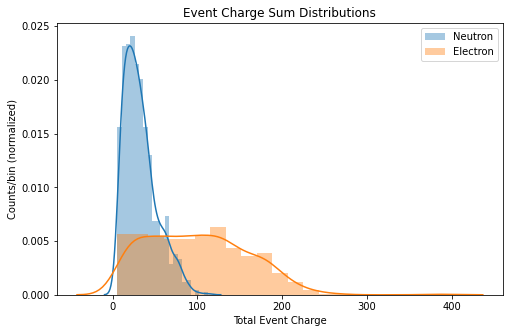

In [20]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 

ax = sns.distplot(neutron_charge_sums, rug = False, axlabel ="Total Event Charge", label = "Neutron")
ax = sns.distplot(electron_charge_sums, rug = False, label = "Electron")
plt.legend()
plt.title("Event Charge Sum Distributions")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("charge_separation.png", bbox_inches = 'tight')

Text(0, 0.5, 'Counts/bin (normalized)')

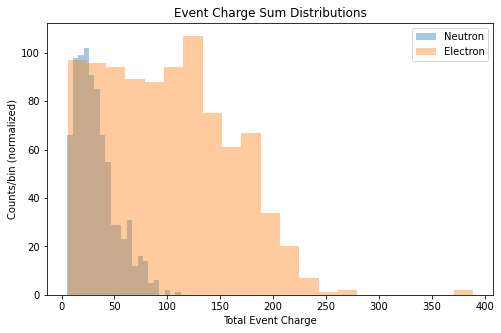

In [21]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 

ax = sns.distplot(neutron_charge_sums, kde=False, rug = False, axlabel ="Total Event Charge", label = "Neutron")
ax = sns.distplot(electron_charge_sums, kde=False, rug = False, label = "Electron")
plt.legend()
plt.title("Event Charge Sum Distributions")
plt.ylabel("Counts/bin (normalized)")
#plt.savefig("charge_separation.png", bbox_inches = 'tight')

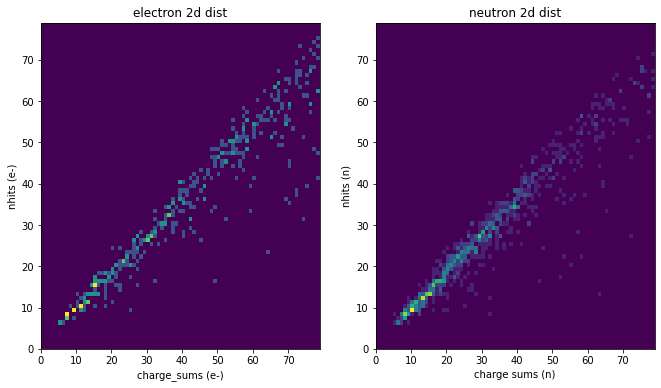

In [22]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize = (11, 6))

ax1.hist2d(electron_charge_sums, electron_hits, bins = np.arange(0, 80, 1), label = 'electron')
ax2.hist2d(neutron_charge_sums, neutron_hits, bins = np.arange(0, 80, 1), label = 'neutron')

ax1.set_xlabel('charge_sums (e-)')
ax1.set_ylabel('nhits (e-)')
ax1.set_title('electron 2d dist')

ax2.set_xlabel('charge sums (n)')
ax2.set_ylabel('nhits (n)')
ax2.set_title('neutron 2d dist')

plt.show()

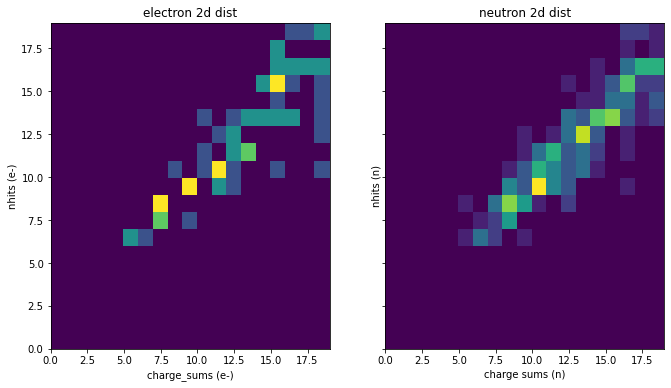

In [23]:
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (11, 6))

ax1.hist2d(electron_charge_sums, electron_hits, bins = np.arange(0, 20, 1), label = 'electron')
ax2.hist2d(neutron_charge_sums, neutron_hits, bins = np.arange(0, 20, 1), label = 'neutron')

ax1.set_xlabel('charge_sums (e-)')
ax1.set_ylabel('nhits (e-)')
ax1.set_title('electron 2d dist')

ax2.set_xlabel('charge sums (n)')
ax2.set_ylabel('nhits (n)')
ax2.set_title('neutron 2d dist')

plt.show()

# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Counts')

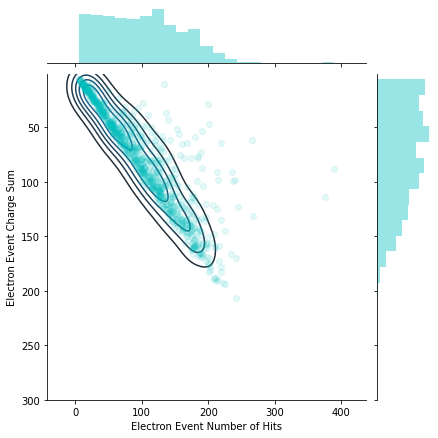

In [24]:
g = (sns.jointplot(electron_charge_sums, electron_hits,
                  color = 'c', height = 6, ylim = 300, alpha = 0.1)
                  .plot_joint(sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Electron Event Number of Hits", "Electron Event Charge Sum"))

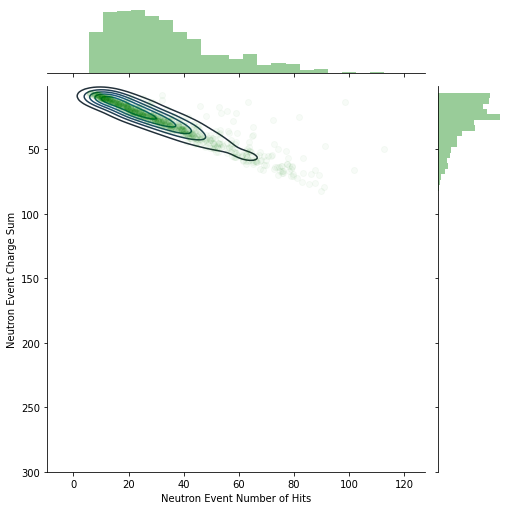

In [25]:
h = (sns.jointplot(neutron_charge_sums, neutron_hits,
                  color = 'g', height = 7, ylim = 300, alpha = 0.03)
                  .plot_joint(sns.kdeplot, zorder=0, n_levels=6).set_axis_labels("Neutron Event Number of Hits", "Neutron Event Charge Sum"))

# Timing...

In [26]:
#load in h5 file and indices files
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_6files.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_6files.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_6files.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_6files.txt"

In [27]:
import seaborn as sns
#this creates a memory map - i.e. events are not loaded in memory here, only on get_item
file = h5py.File(h5_filepath,'r')
h5_event_data = file["event_data"]
h5_labels = file["labels"]
h5_nhits = file["nhits"]
labels = np.array(h5_labels)
nhits = np.array(h5_nhits)

event_data_offset = h5_event_data.id.get_offset()
event_data_dtype = h5_event_data.dtype   

event_data = np.memmap(h5_filepath, mode='r', 
                            shape=h5_event_data.shape,
                            offset=event_data_offset, 
                            dtype=event_data_dtype)

In [28]:
print(event_data[0, :nhits[0], 1])
print(event_data[1, :nhits[1], 1])

[ 952.   960.3  948.8  945.8  943.5  965.4  944.8  932.3 1821.4]
[ 973.4  958.1  964.2  961.9  956.3  963.3  957.7  963.3  955.4  950.2
  957.2  971.4  966.3  952.2  957.3  969.5  957.   961.4  950.9  956.7
  950.8  952.6  952.9  954.6  959.9  955.3  955.1  954.8  951.3  951.7
  958.1  951.8  957.3  956.4  957.8  951.4  957.8  955.2  963.3  955.4
  954.9  960.3  955.1  951.   980.3  954.   972.1  959.5  952.4  965.1
  970.2  955.8  950.7  953.3  951.   977.   956.2  977.8  951.   957.2
  951.7  963.8  955.6  957.9  958.6  953.3  953.9  955.9  953.3  952.1
  955.3  963.4  953.4  952.5  951.9  976.   955.9  957.7  953.9  958.6
  954.9  960.5  955.   959.   951.6  962.   950.9  951.   953.9  955.2
  952.4  961.8  974.8  954.   953.8  955.8  956.5  954.9  957.8  952.5
  951.4  965.4  952.7  963.4  956.9  952.2  954.7  959.6  954.   962.2
  965.7  961.4  954.7  963.3  952.9  952.2  954.8  957.7  961.6  956.5
  954.2  957.5  955.4  993.1  953.8 1001.3  951.7  988.6  960.7  958.2
  965.5  954

In [29]:
neutron_times = []
electron_times = []
neutron_indices = []
electron_indices = []

for i in range(event_data.shape[0]):
    if labels[i] == 0:
        neutron_times.append(event_data[i, :, 1])
        neutron_indices.append(i)
    elif labels[i] == 1:
        electron_times.append(event_data[i, :, 1])   
        electron_indices.append(i)

In [30]:
neutron_times = np.array(neutron_times)
electron_times = np.array(electron_times)

print(neutron_times.shape)
print(electron_times.shape)

(2484, 300)
(2754, 300)


In [31]:
print(max(neutron_times[0, :nhits[neutron_indices[0]]]) - min(neutron_times[0, :nhits[neutron_indices[0]]]))

1127.1992


__average, min, max and range of event times__

In [32]:
n_timeRange = []; n_minTimes = []; n_maxTimes = []; n_meanTimes = []
e_timeRange = []; e_minTimes = []; e_maxTimes = []; e_meanTimes = []

for i in range(len(neutron_times)):
    n_timeRange.append(max(neutron_times[i, :nhits[neutron_indices[i]]]) - min(neutron_times[i, :nhits[neutron_indices[i]]]))
    n_minTimes.append(min(neutron_times[i, :nhits[neutron_indices[i]]]))
    n_maxTimes.append(max(neutron_times[i, :nhits[neutron_indices[i]]]))
    n_meanTimes.append(np.average(neutron_times[i, :nhits[neutron_indices[i]]]))
    
for i in range(len(electron_times)):
    e_timeRange.append(max(electron_times[i, :nhits[electron_indices[i]]]) - min(electron_times[i, :nhits[electron_indices[i]]]))
    e_minTimes.append(min(electron_times[i, :nhits[electron_indices[i]]]))
    e_maxTimes.append(max(electron_times[i, :nhits[electron_indices[i]]]))
    e_meanTimes.append(np.average(electron_times[i, :nhits[electron_indices[i]]]))

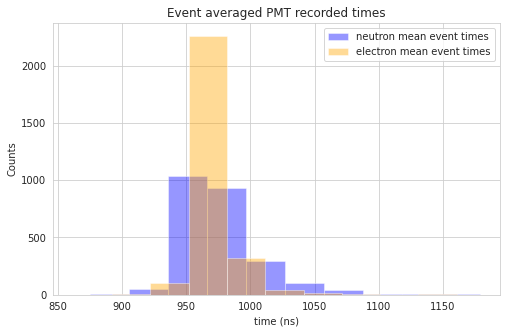

In [33]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_meanTimes, color = 'blue', alpha = 0.41, label = 'neutron mean event times')
plt.hist(e_meanTimes, color = 'orange', alpha = 0.41, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event averaged PMT recorded times")
plt.legend()

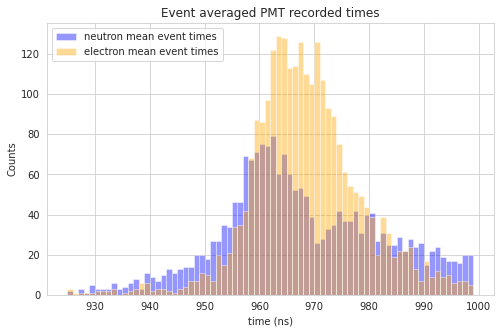

In [34]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_meanTimes, bins=np.arange(925,1000,1), color = 'blue', alpha = 0.41, label = 'neutron mean event times')
plt.hist(e_meanTimes, bins=np.arange(925,1000,1), color = 'orange', alpha = 0.41, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event averaged PMT recorded times")
plt.legend()

In [35]:
print(stats.describe(n_timeRange))
print(stats.describe(e_timeRange))

DescribeResult(nobs=2484, minmax=(4.203125, 1329.6997), mean=443.8319, variance=120082.61, skewness=0.39261117577552795, kurtosis=-1.0570004244513507)
DescribeResult(nobs=2754, minmax=(2.2999878, 1318.3999), mean=431.9403, variance=112106.836, skewness=0.4454105496406555, kurtosis=-0.9891367680741538)


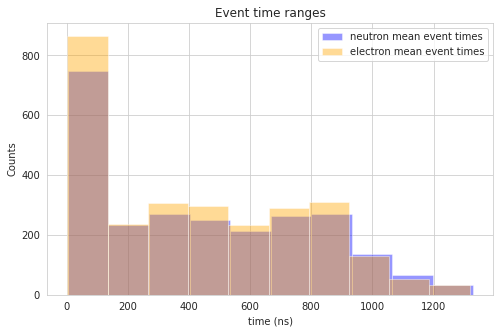

In [36]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_timeRange, color = 'blue', alpha = 0.41, label = 'neutron mean event times')
plt.hist(e_timeRange, color = 'orange', alpha = 0.41, label = 'electron mean event times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event time ranges")
plt.legend()

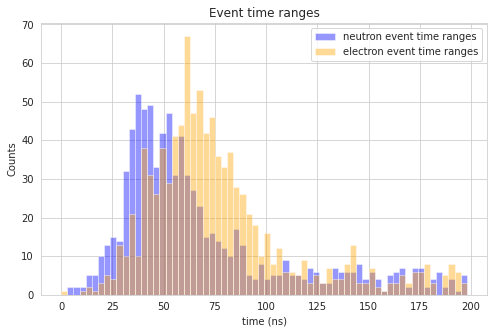

In [37]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_timeRange, bins=np.arange(0, 200, 3), color = 'blue', alpha = 0.41, label = 'neutron event time ranges')
plt.hist(e_timeRange, bins=np.arange(0, 200, 3), color = 'orange', alpha = 0.41, label = 'electron event time ranges')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event time ranges")
plt.legend()

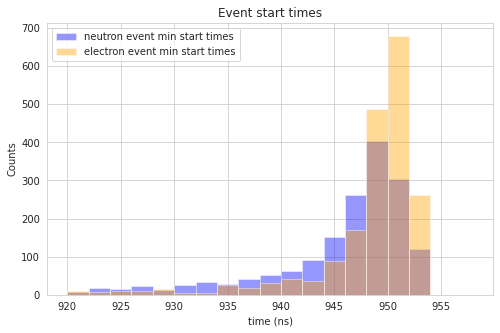

In [38]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_minTimes, color = 'blue', bins=np.arange(920,960,2), alpha = 0.41, label = 'neutron event min start times')
plt.hist(e_minTimes, color = 'orange', bins=np.arange(920,960,2), alpha = 0.41, label = 'electron event min start times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event start times")
plt.legend()

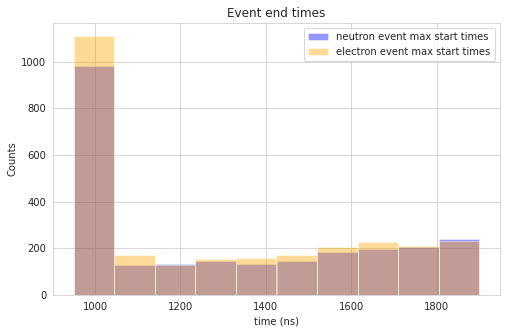

In [39]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_maxTimes, color = 'blue', alpha = 0.41, label = 'neutron event max start times')
plt.hist(e_maxTimes, color = 'orange', alpha = 0.41, label = 'electron event max start times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event end times")
plt.legend()

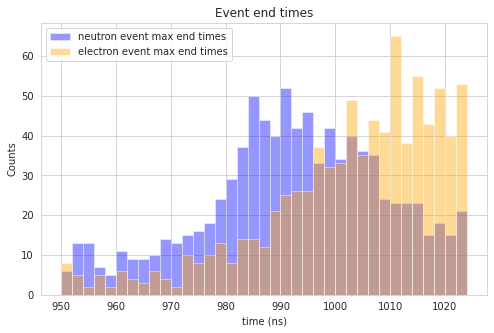

In [40]:
sns.set_style('whitegrid')
plt.figure(figsize = (8,5))
plt.hist(n_maxTimes, color = 'blue', bins=np.arange(950,1025,2), alpha = 0.41, label = 'neutron event max end times')
plt.hist(e_maxTimes, color = 'orange', bins=np.arange(950,1025,2), alpha = 0.41, label = 'electron event max end times')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.title("Event end times")
plt.legend()

# Energy

In [41]:
#load in h5 file and indices files
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_6files.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_6files.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_6files.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_6files.txt"

In [42]:
file = h5py.File(h5_filepath,'r')
print(file.keys())
h5_event_data = file["event_data"]
h5_labels = file["labels"]
h5_nhits = file["nhits"]
labels = np.array(h5_labels)
nhits = np.array(h5_nhits)
h5_energy = file["energies"]

event_data_offset = h5_event_data.id.get_offset()
event_data_dtype = h5_event_data.dtype   

event_data = np.memmap(h5_filepath, mode='r', 
                            shape=h5_event_data.shape,
                            offset=event_data_offset, 
                            dtype=event_data_dtype)

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']>


In [43]:
print(event_data.shape)
print(h5_energy.shape)

(5238, 300, 8)
(5238, 1)


In [44]:
h5_energy = np.array(h5_energy)
h5_energy = np.reshape(h5_energy, (len(h5_energy), -1))
h5_energy = h5_energy.flatten()

In [45]:
print(h5_energy.shape)

(5238,)


In [46]:
print(h5_energy[:10])

[ 2.455001  17.7344     8.345588   7.2608953 10.2409315 15.283396
  4.7484903 17.320034  14.434585  17.561407 ]


Text(0, 0.5, 'Counts/bin')

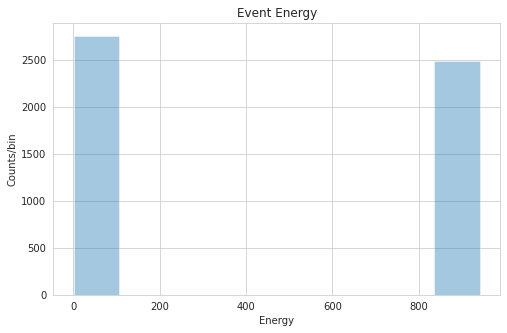

In [47]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(h5_energy, rug = False, kde=False, axlabel ="Energy", norm_hist=False)
plt.title("Event Energy")
plt.ylabel("Counts/bin")

In [48]:
n_energies = []
e_energies = []

for i, j in enumerate(h5_energy):
    if labels[i] == 0: #neutron
        n_energies.append(j)
    elif labels[i] == 1:  #electron
        e_energies.append(j)

Text(0, 0.5, 'Counts/bin')

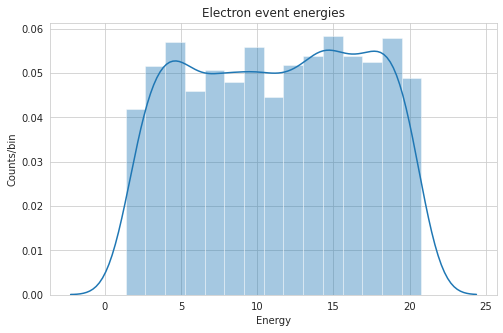

In [49]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(e_energies, rug = False, kde=True, axlabel ="Energy", norm_hist=False)
plt.title("Electron event energies")
plt.ylabel("Counts/bin")

In [50]:
print(n_energies[:10])
print(e_energies[:25])

[940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537, 940.56537]
[2.455001, 17.7344, 8.345588, 7.2608953, 10.2409315, 15.283396, 4.7484903, 17.320034, 14.434585, 17.561407, 2.6265004, 9.29109, 7.022642, 11.823462, 19.995197, 4.6773877, 1.4463165, 10.411381, 12.787431, 5.326019, 4.5077577, 14.31107, 14.90849, 17.555962, 3.932655]


Text(0, 0.5, 'Counts/bin')

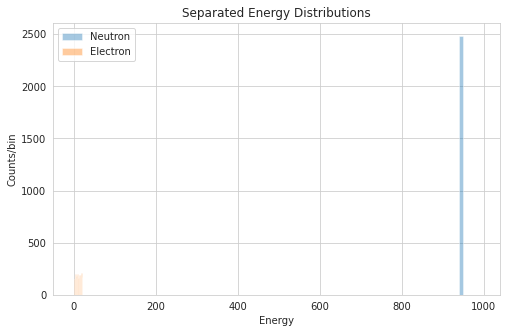

In [51]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111) 
sns.distplot(n_energies, kde=False, rug = False, bins=np.arange(0, 1000, 10), axlabel ="Energy", label = "Neutron")
sns.distplot(e_energies, kde=False, rug = False, label = "Electron")
plt.legend()
plt.title("Separated Energy Distributions")
plt.ylabel("Counts/bin")

In [52]:
print(stats.describe(n_energies))
print(stats.describe(e_energies))

DescribeResult(nobs=2484, minmax=(940.56537, 940.56537), mean=940.5653, variance=3.7267904e-09, skewness=1.0, kurtosis=-2.0)
DescribeResult(nobs=2754, minmax=(1.3630118, 20.768019), mean=11.285846, variance=30.701263, skewness=-0.04225729778409004, kurtosis=-1.224220650500978)


# Sorting by Time

function to sort hits in an event in order of time (ascending or descending)

In [76]:
file = h5py.File(h5_filepath,'r')
h5_event_data = file["event_data"]
h5_labels = file["labels"]
h5_nhits = file["nhits"]
labels = np.array(h5_labels)

event_data_offset = h5_event_data.id.get_offset()
event_data_dtype = h5_event_data.dtype   
event_data_shape = h5_event_data.shape

event_data = np.memmap(h5_filepath, mode='c', 
                            shape = event_data_shape,
                            offset=event_data_offset, 
                            dtype=event_data_dtype)

In [63]:
def sortTimeDesc(x):
    event_data[x] = event_data[x][np.argsort(-event_data[x][:, 1])] 
    
def sortTimeAsc(x): 
    temp = event_data[x][np.argsort(event_data[x][:h5_nhits[x], 1])]
    event_data[x] = np.append(temp, np.zeros((300-h5_nhits[x], 8)), axis = 0)

set numpy memory map to 'copy' mode for the event data

create feature names for the time sorted hits in the event, e.g. 'charge of 5th hit', 'x_PMT_position of 22nd hit', etc.

In [64]:
feature_names = []

for x in np.arange(0, 2400, 1):
    if x % 8 == 0:
        if x == 0:
            feature_names.append("charge(hit{})".format(str(0)))
        else:
            feature_names.append("charge(hit{})".format(str(int(x/8))))
    elif x % 8 == 1:
        feature_names.append("time(hit{})".format(str(int(x/8))))
    elif x % 8 == 2:
        feature_names.append("xpos(hit{})".format(str(int(x/8))))
    elif x % 8 == 3:
        feature_names.append("ypos(hit{})".format(str(int(x/8))))
    elif x % 8 == 4:
        feature_names.append("zpos(hit{})".format(str(int(x/8))))
    elif x % 8 == 5:
        feature_names.append("xdir(hit{})".format(str(int(x/8))))
    elif x % 8 == 6:
        feature_names.append("ydir(hit{})".format(str(int(x/8))))
    elif x % 8 == 7:
        feature_names.append("zdir(hit{})".format(str(int(x/8))))

In [65]:
train_indices = load_indicies(train_indices_file)
train_indices.sort()

In [77]:
#sort events
for x in range(event_data.shape[0]):
    sortTimeAsc(x)

__view time sorted data__

In [78]:
print(event_data.shape)

(5238, 300, 8)


In [83]:
for x in range(4):
    print(event_data[x][:nhits[x], 1])

[ 932.3  943.5  944.8  945.8  948.8  952.   960.3  965.4 1821.4]
[ 759.7  950.2  950.7  950.8  950.9  950.9  951.   951.   951.   951.
  951.3  951.4  951.4  951.6  951.7  951.7  951.7  951.8  951.9  952.1
  952.1  952.2  952.2  952.2  952.4  952.4  952.5  952.5  952.6  952.7
  952.7  952.9  952.9  953.3  953.3  953.3  953.4  953.8  953.8  953.9
  953.9  953.9  954.   954.   954.   954.   954.2  954.6  954.7  954.7
  954.7  954.8  954.8  954.8  954.9  954.9  954.9  955.   955.1  955.1
  955.2  955.2  955.3  955.3  955.4  955.4  955.4  955.6  955.8  955.8
  955.9  955.9  956.2  956.3  956.4  956.5  956.5  956.7  956.9  957.
  957.2  957.2  957.3  957.3  957.5  957.7  957.7  957.7  957.8  957.8
  957.8  957.9  957.9  958.1  958.1  958.2  958.6  958.6  958.7  958.8
  959.   959.2  959.5  959.6  959.9  960.3  960.5  960.7  961.4  961.4
  961.4  961.4  961.6  961.8  961.8  961.9  962.   962.2  962.9  963.2
  963.3  963.3  963.3  963.3  963.4  963.4  963.8  964.2  964.4  964.9
  965.1  965.1

In [70]:
print(event_data[0])

[   1.0039525  932.3       -220.90796   ...    0.           0.
    0.       ]


__neutron vs electron times__

In [85]:
def plot_timing(hit):
    neutron_timing = [];  electron_timing = []; 

    for x in range(event_data.shape[0]):
        if labels[x] == 0:
            neutron_timing.append(event_data[x][hit, 1])
        elif labels[x] == 1:
            electron_timing.append(event_data[x][hit, 1])

    sns.set_style('whitegrid')
    plt.figure(figsize = (12,6))
    plt.hist(neutron_timing, alpha = 0.5, bins = np.arange(900, 980, 2), label = 'time hit {}, neutron'.format(hit))
    plt.hist(electron_timing, alpha = 0.5, bins = np.arange(900, 980, 2), label = 'time hit {}, electron'.format(hit))
    plt.xlabel('time(ns)'); plt.title("Time Ditribution on hit {}".format(hit))
    plt.ylabel('Counts\bin')
    plt.legend()

/home/mattStubbs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/home/mattStubbs/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mattStubbs/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


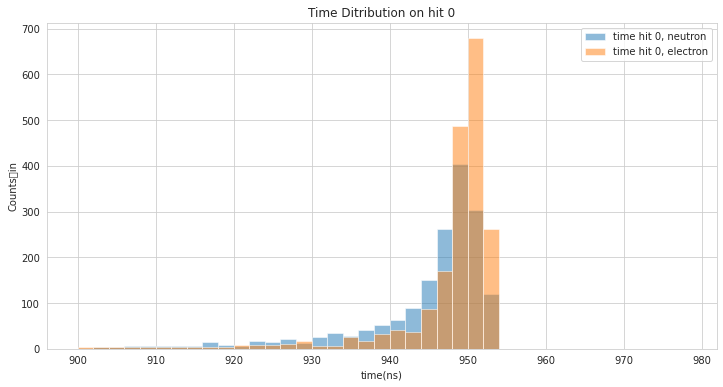

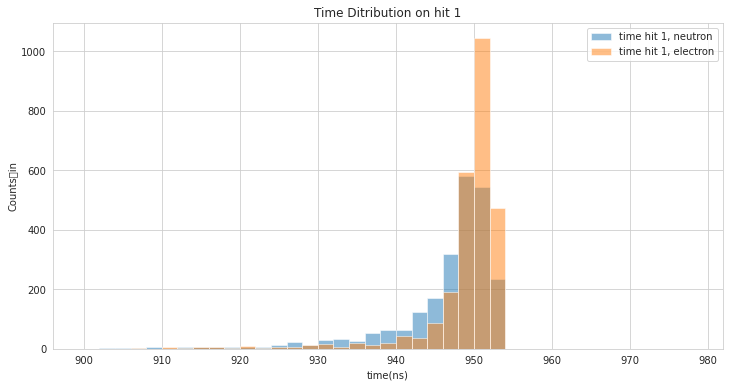

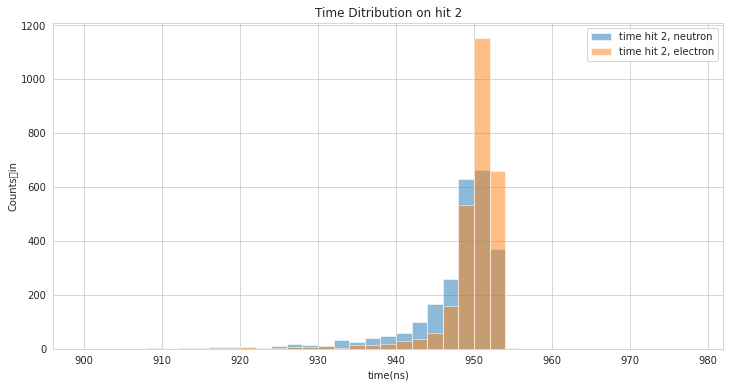

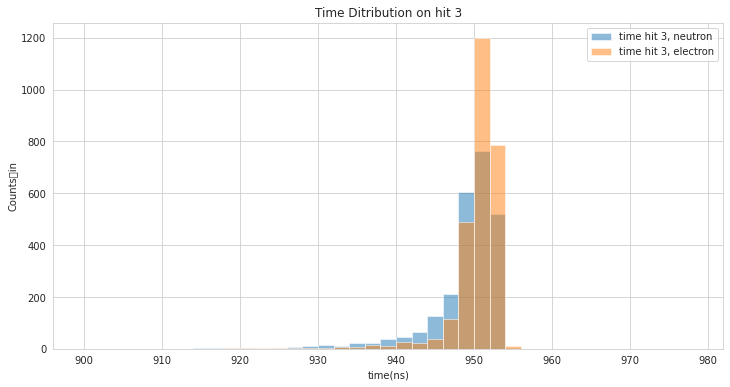

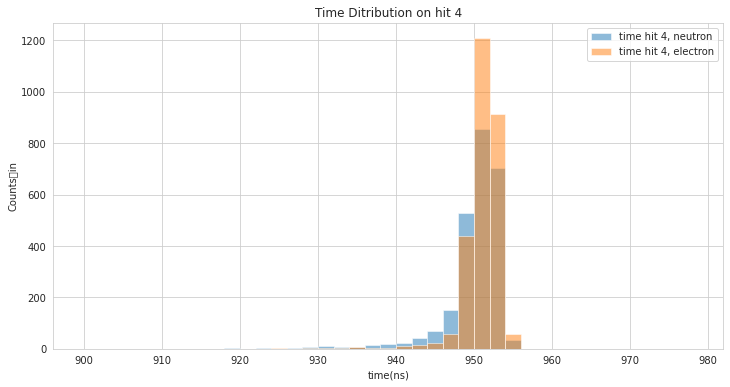

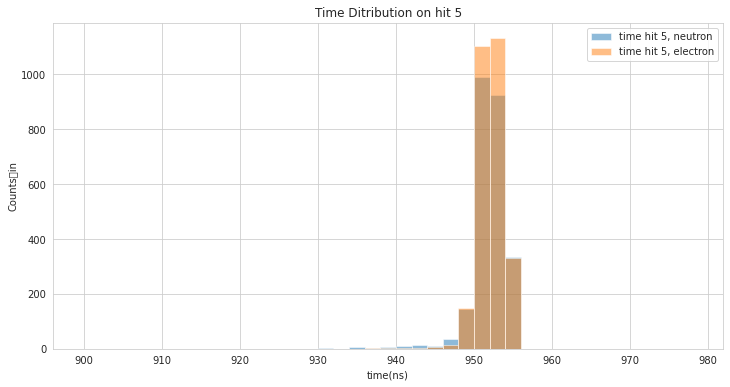

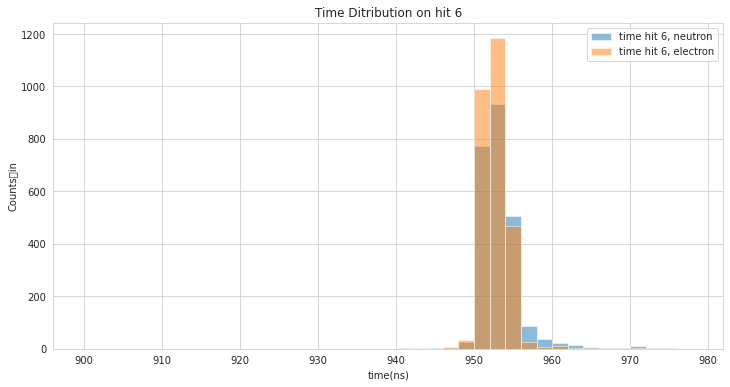

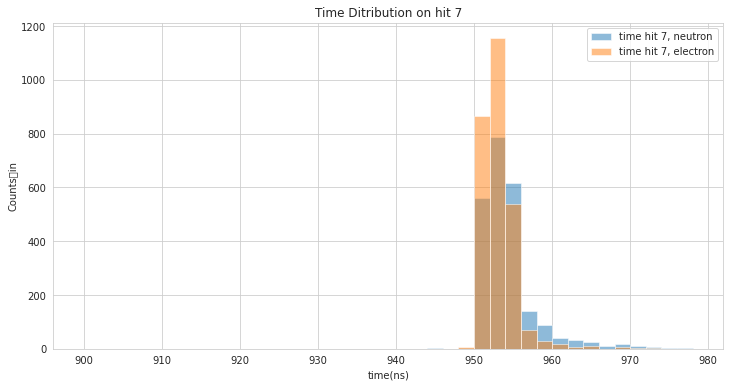

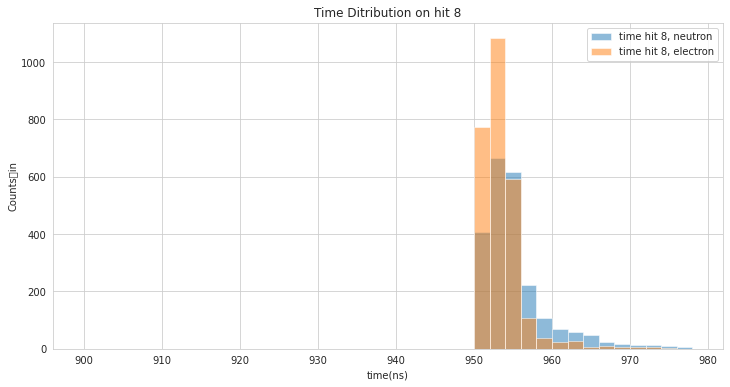

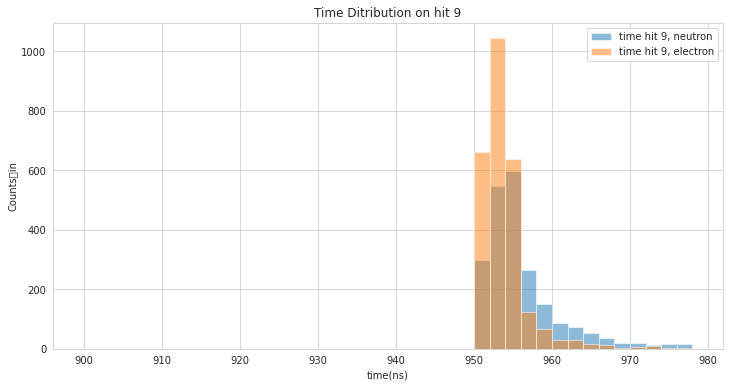

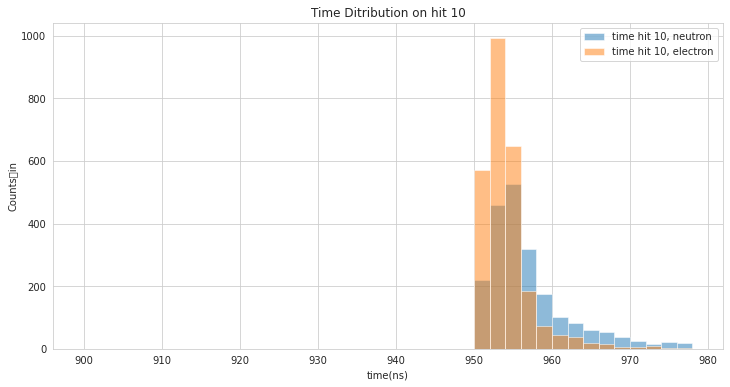

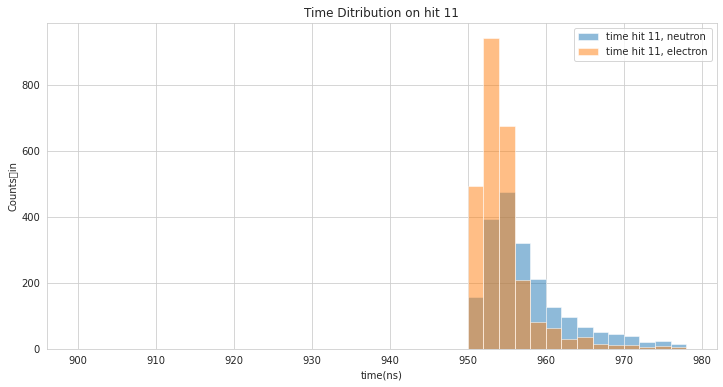

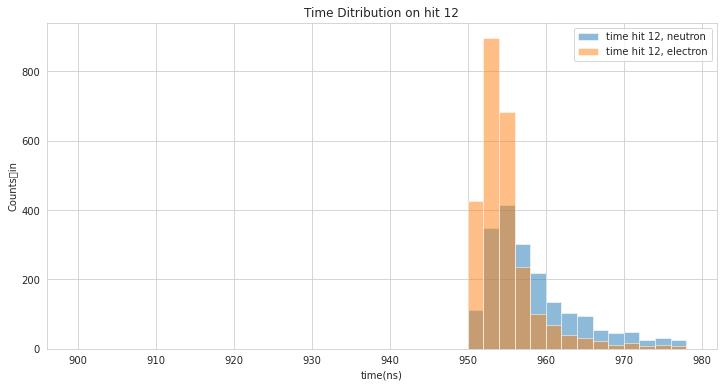

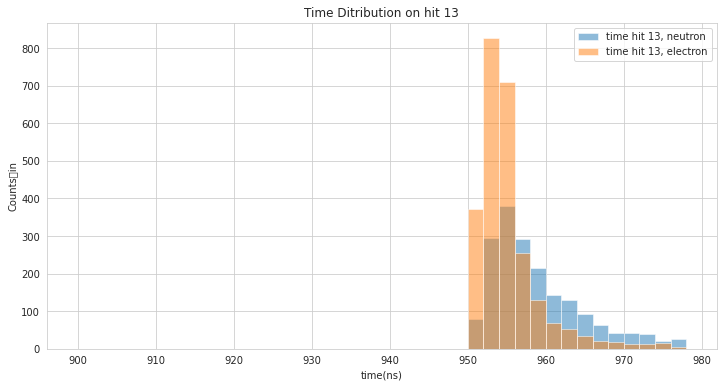

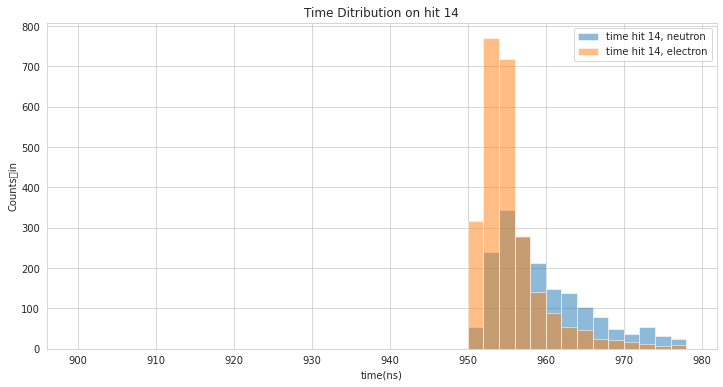

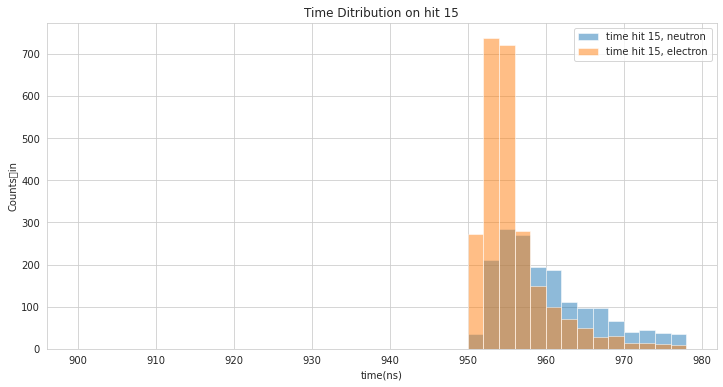

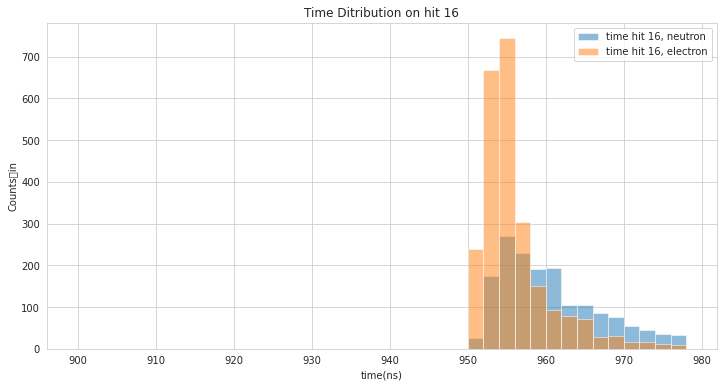

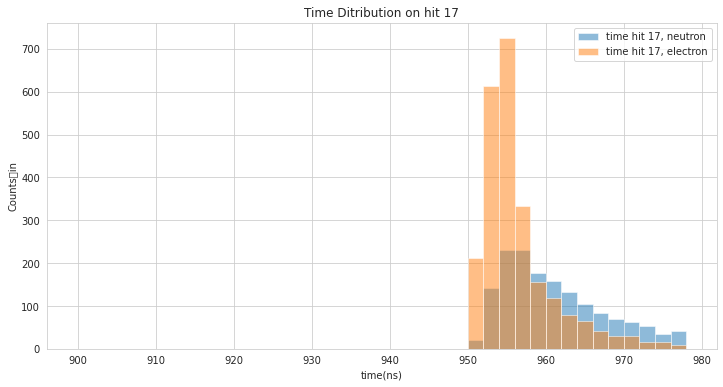

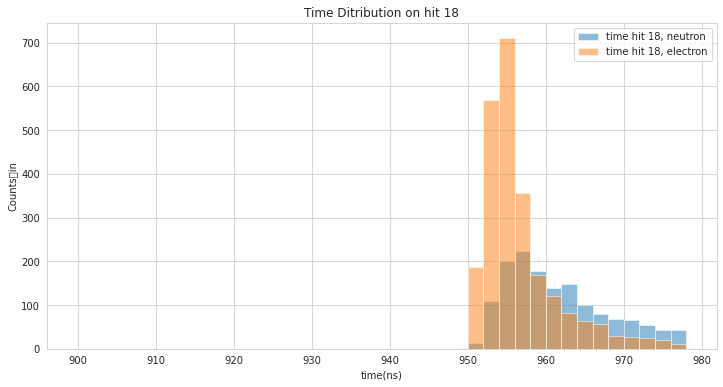

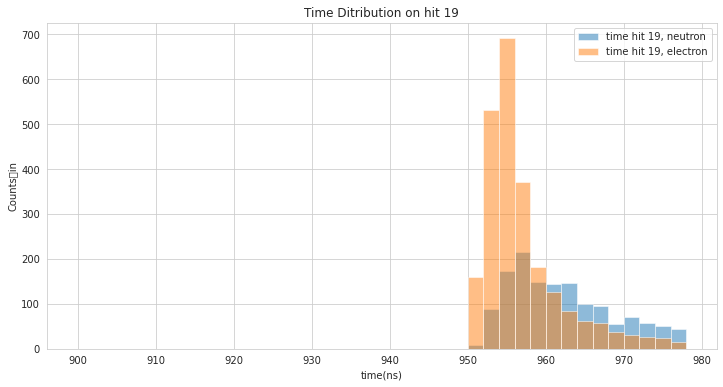

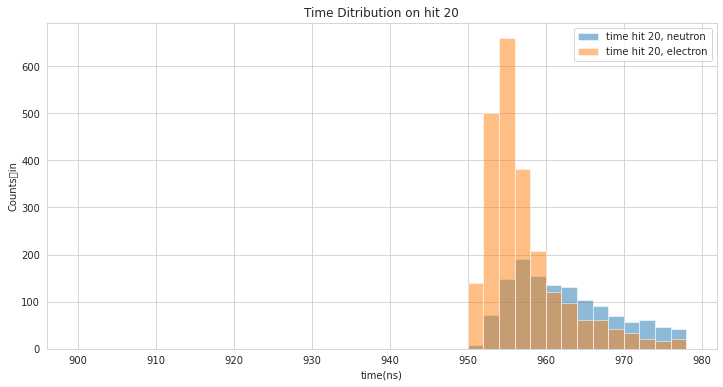

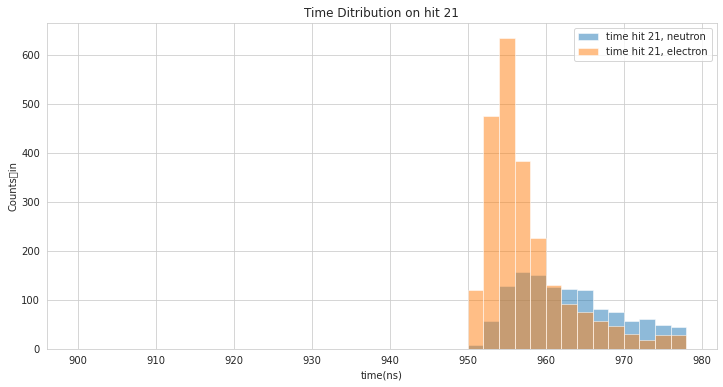

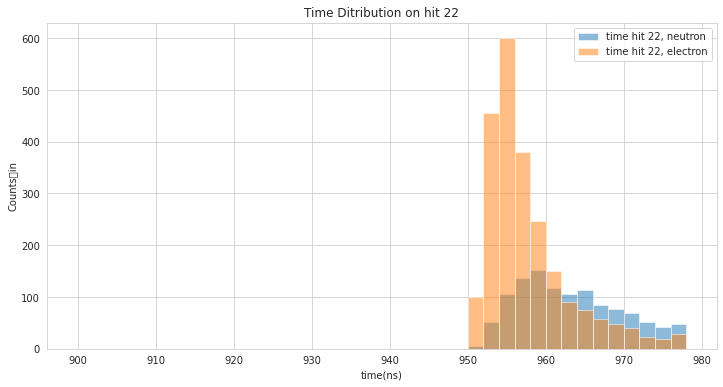

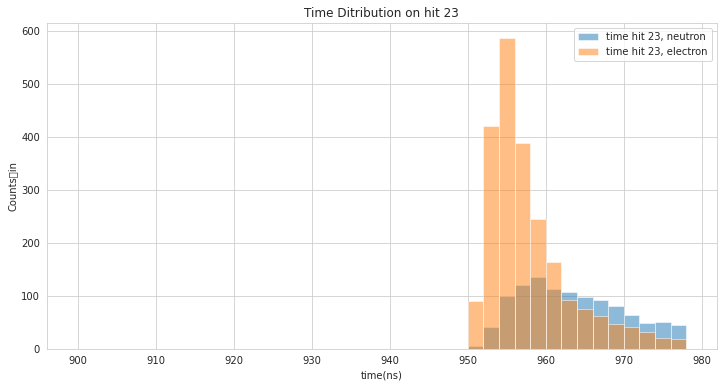

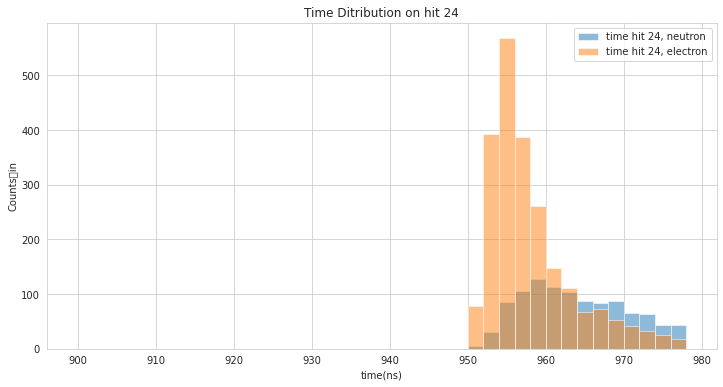

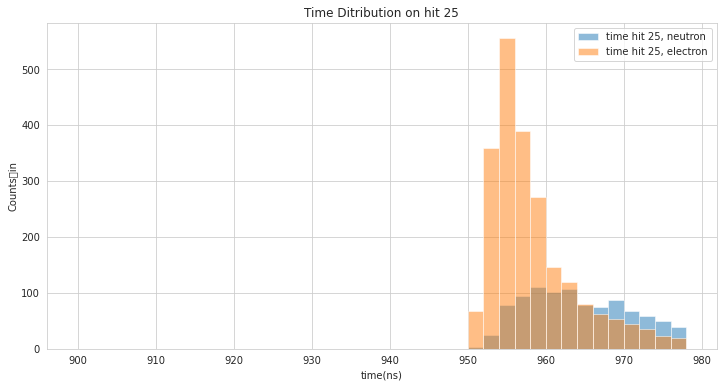

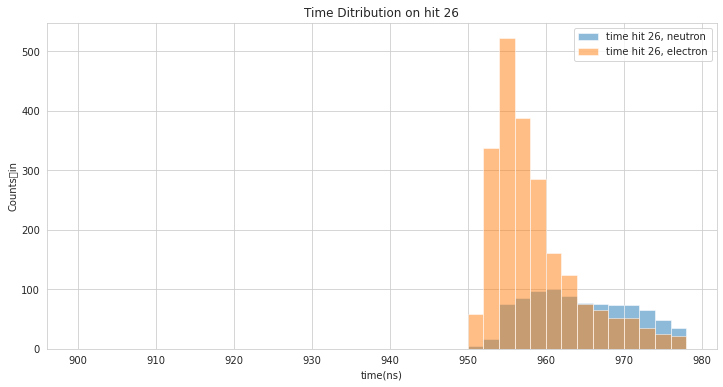

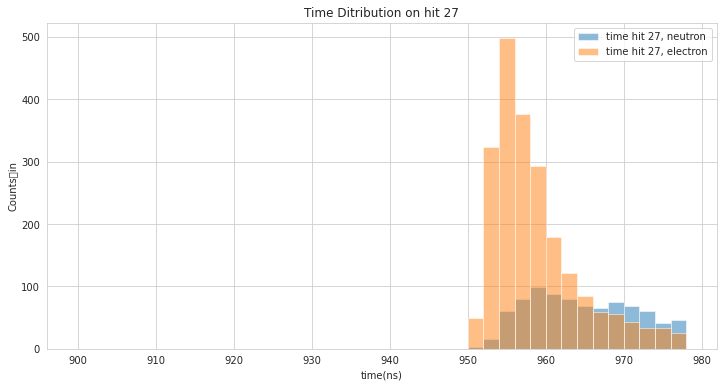

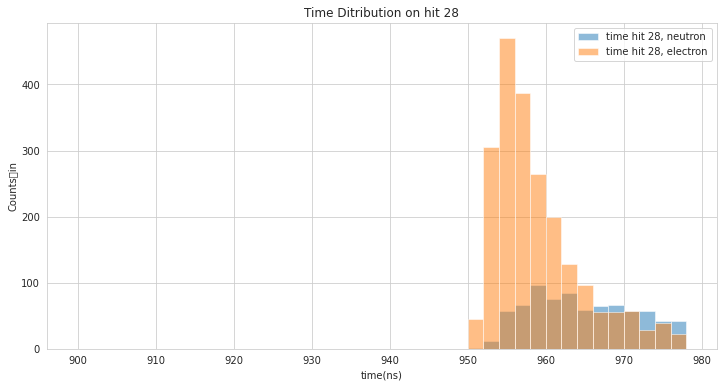

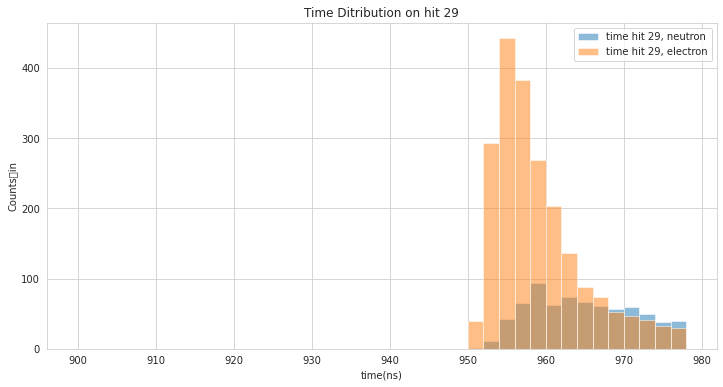

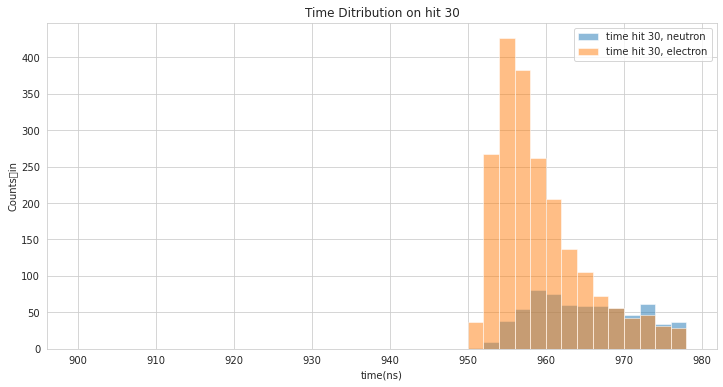

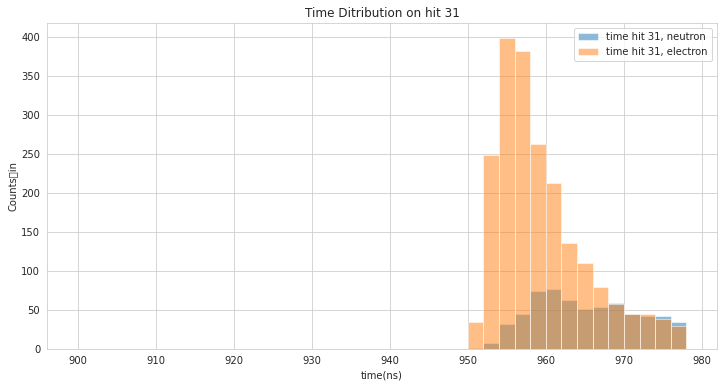

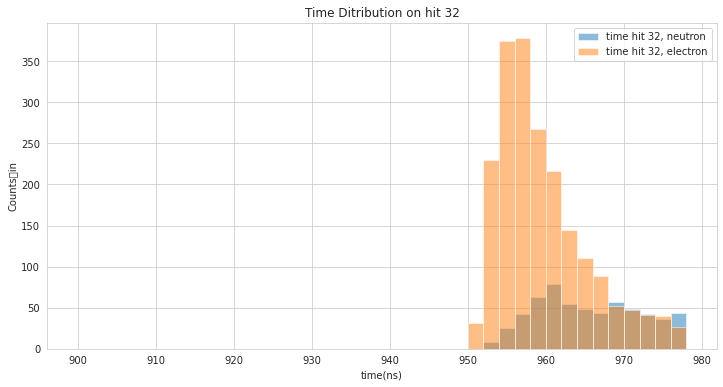

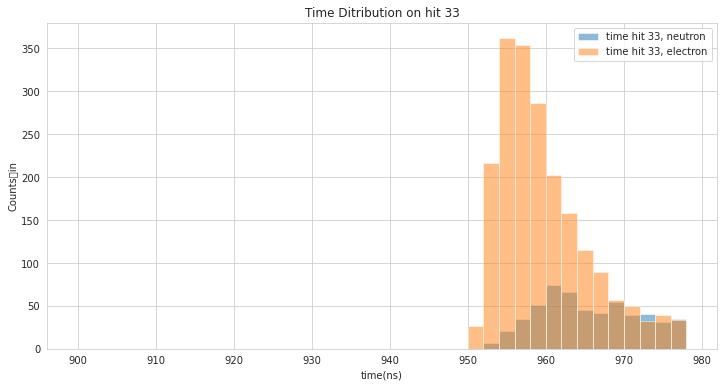

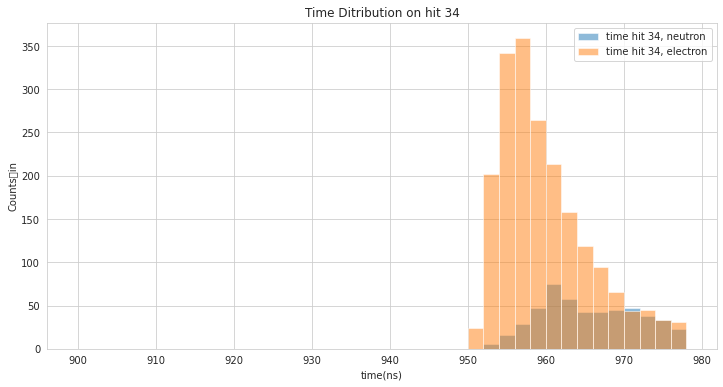

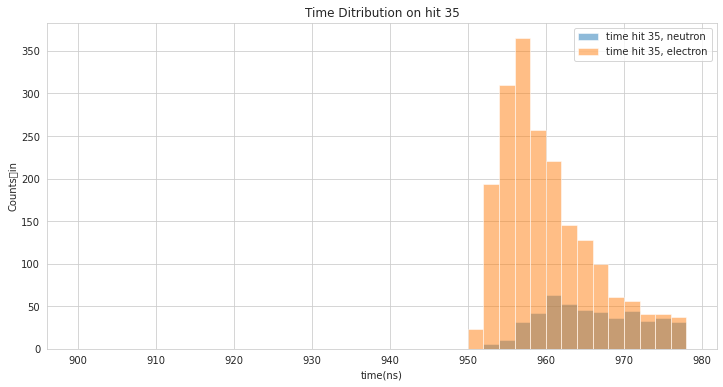

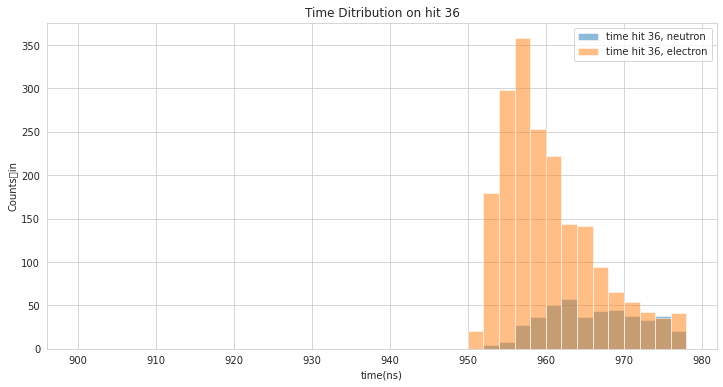

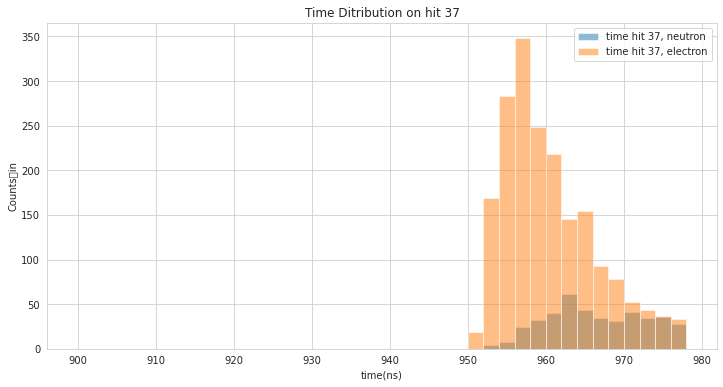

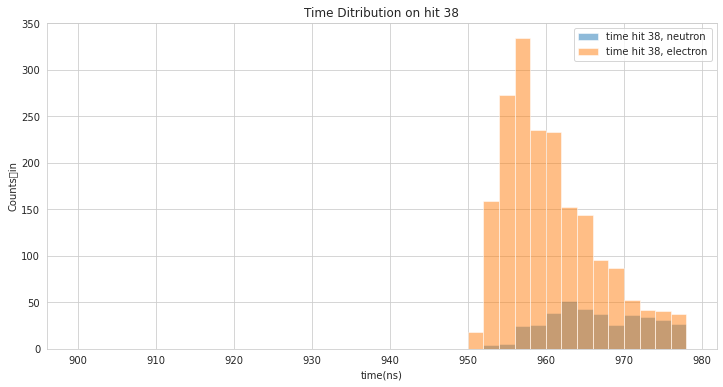

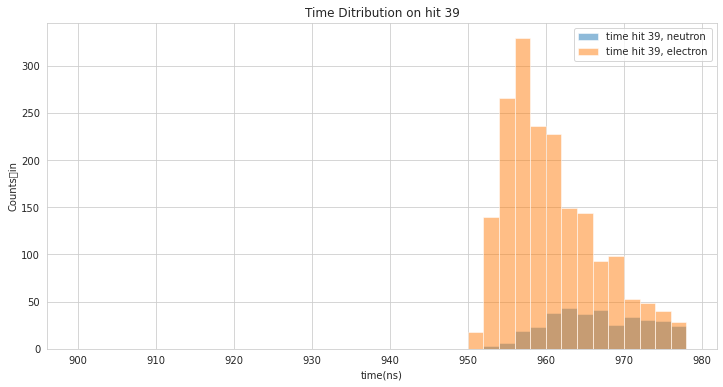

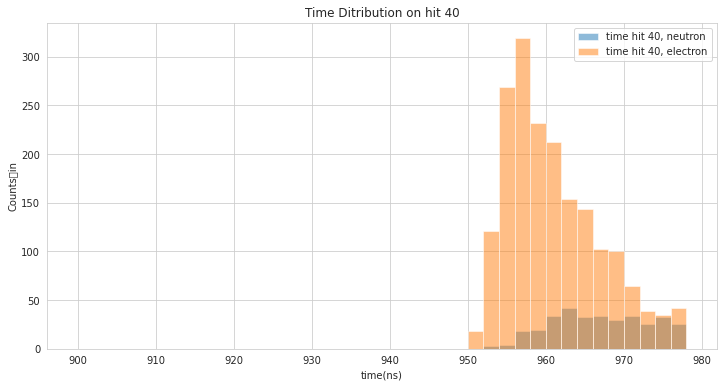

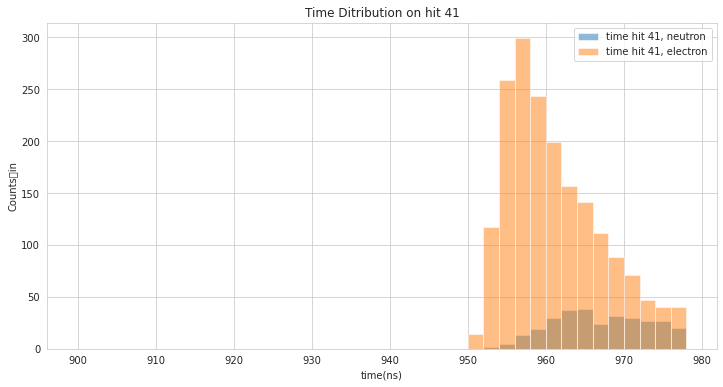

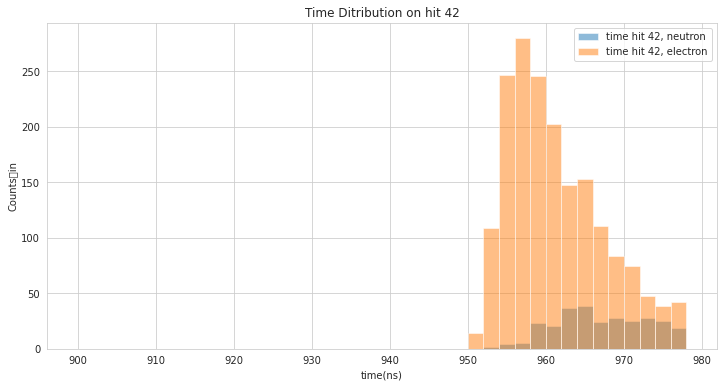

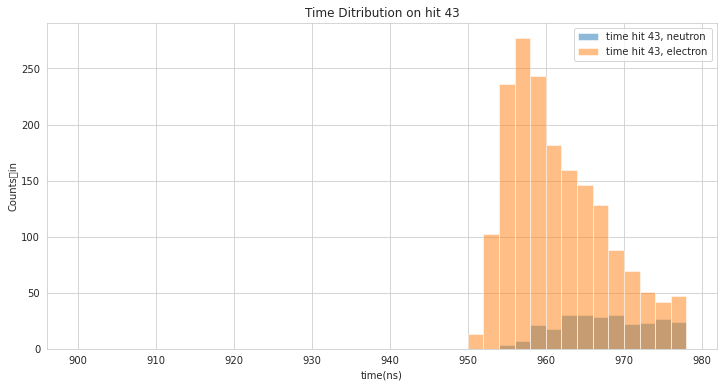

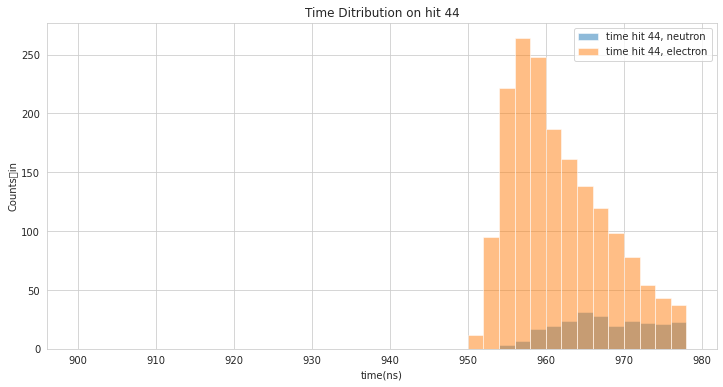

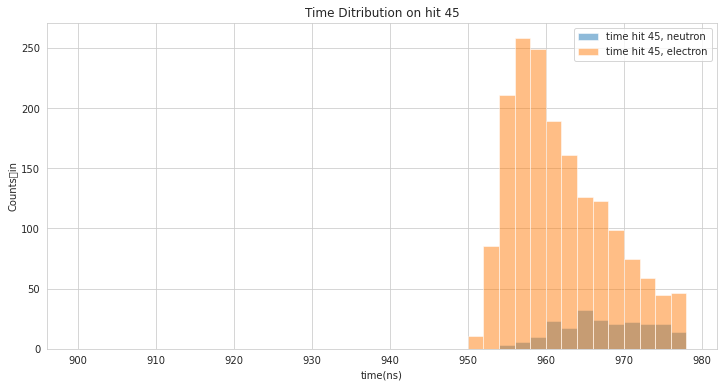

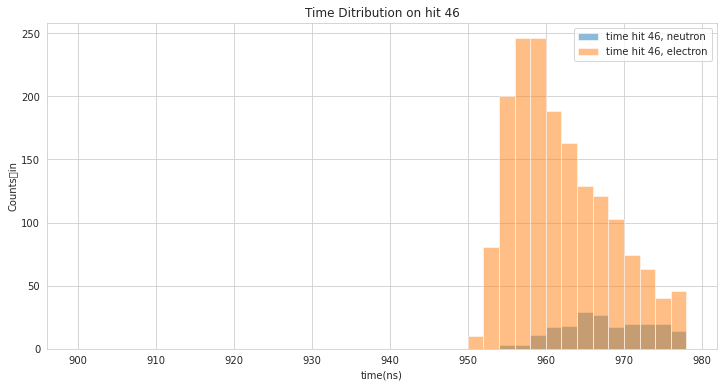

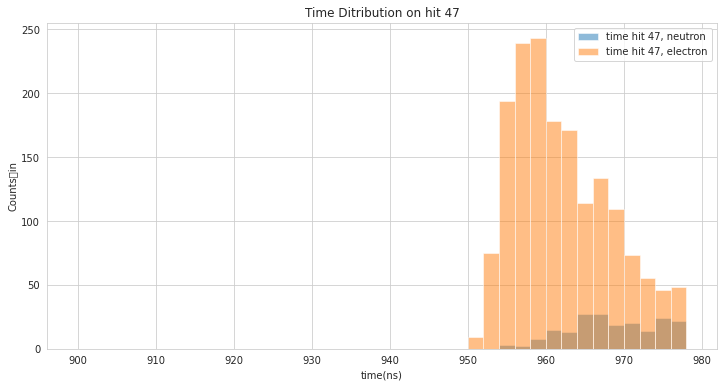

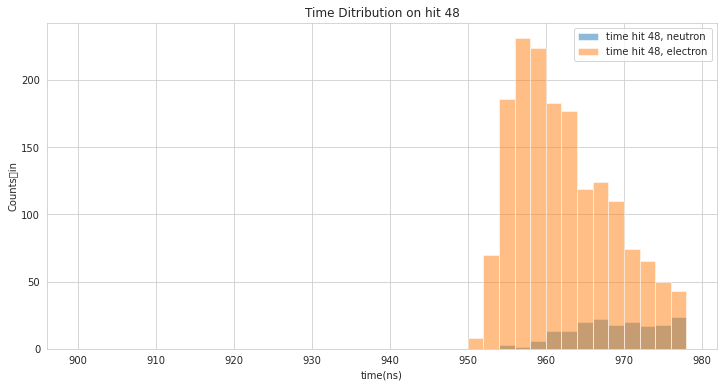

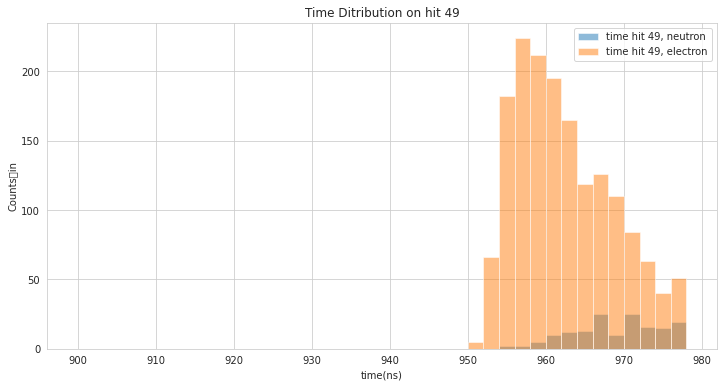

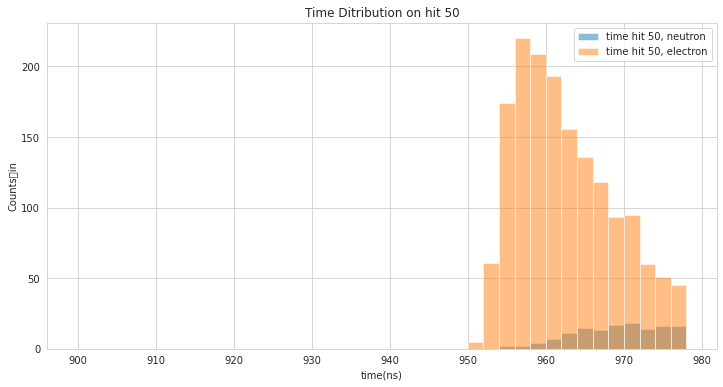

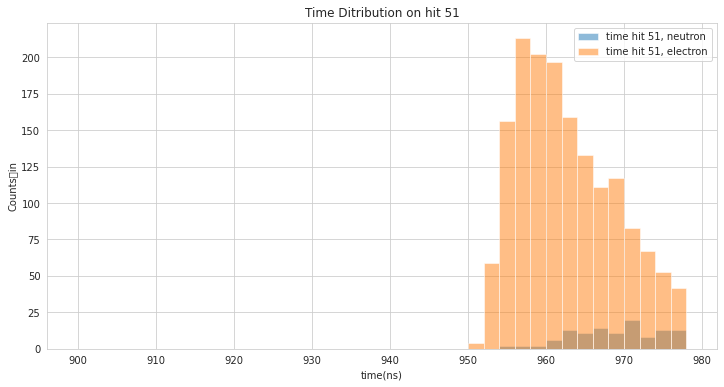

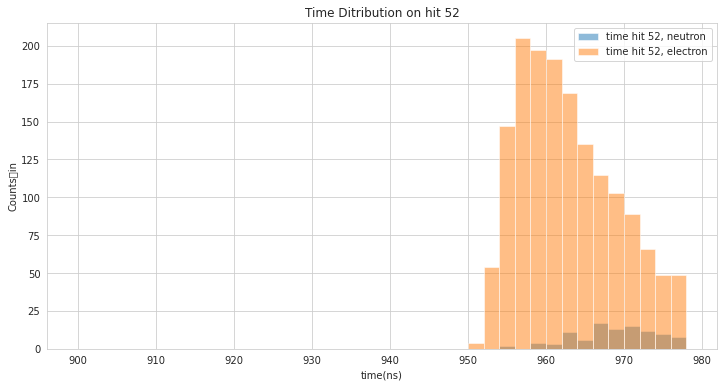

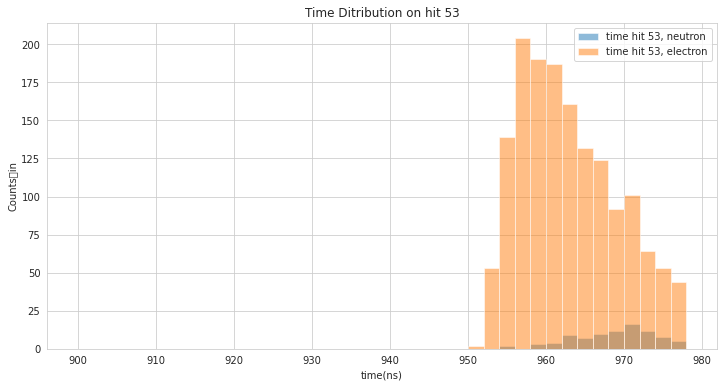

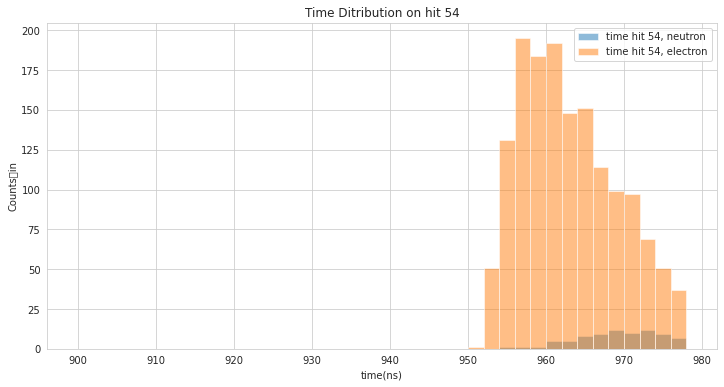

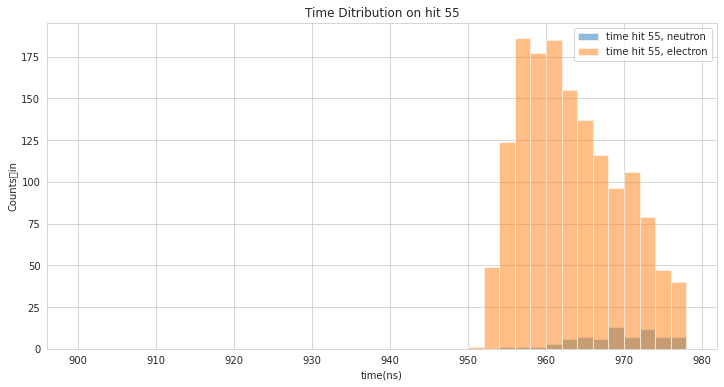

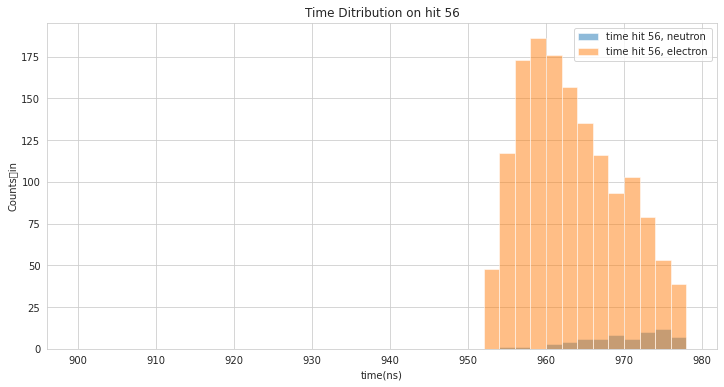

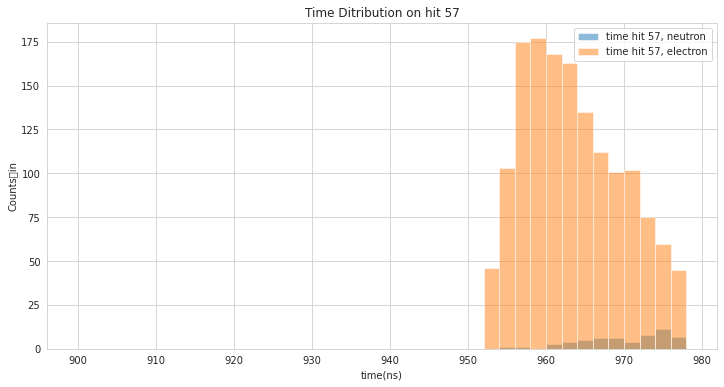

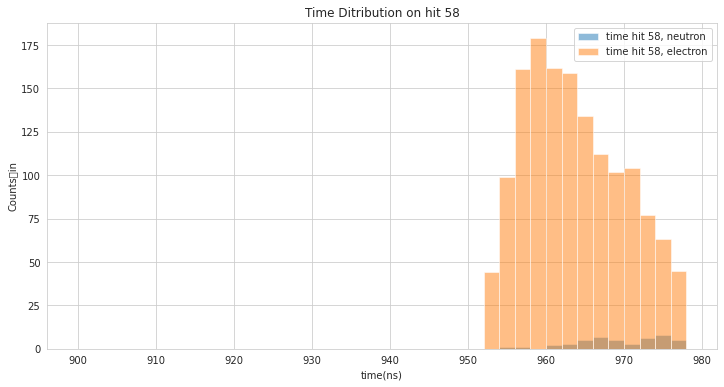

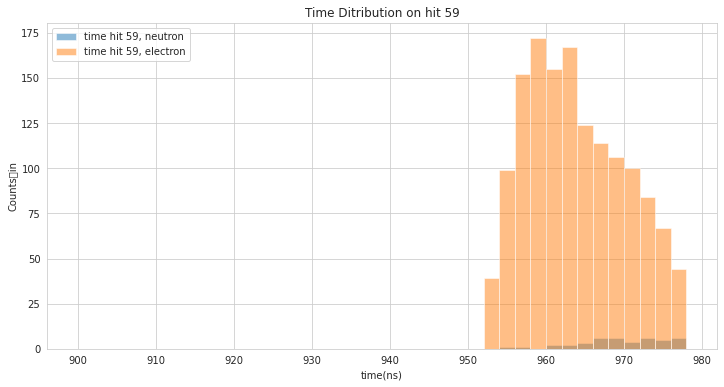

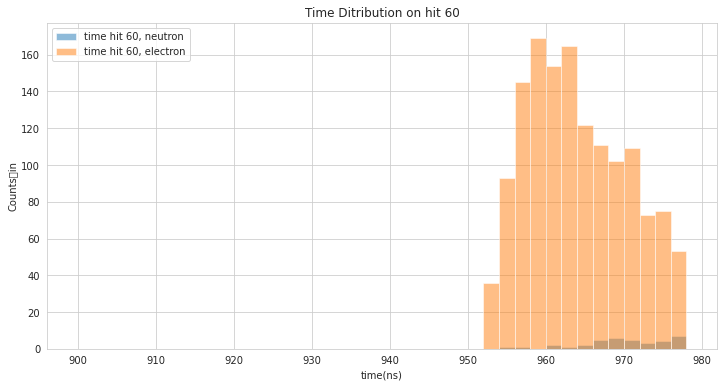

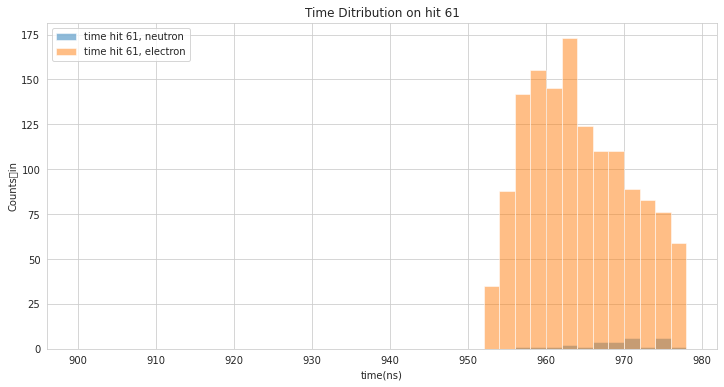

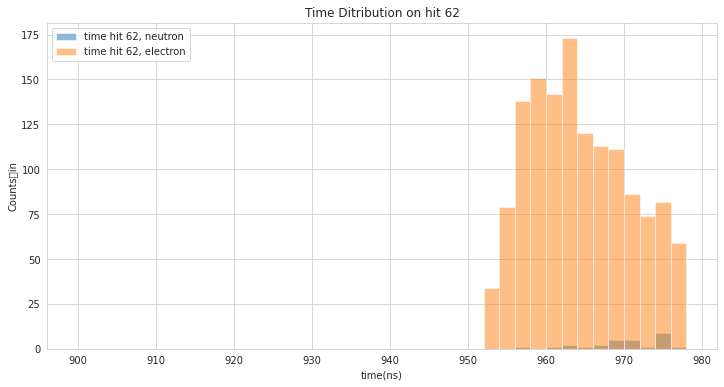

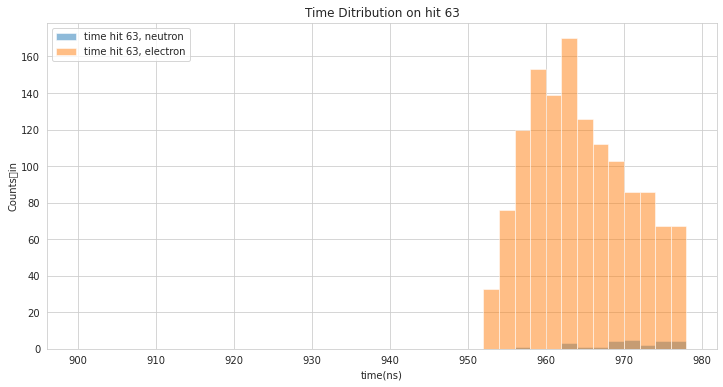

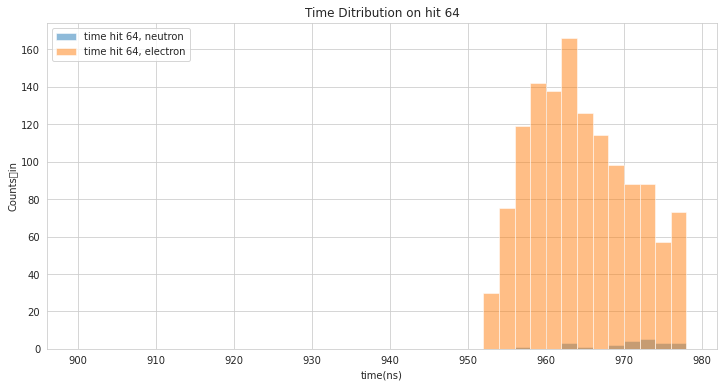

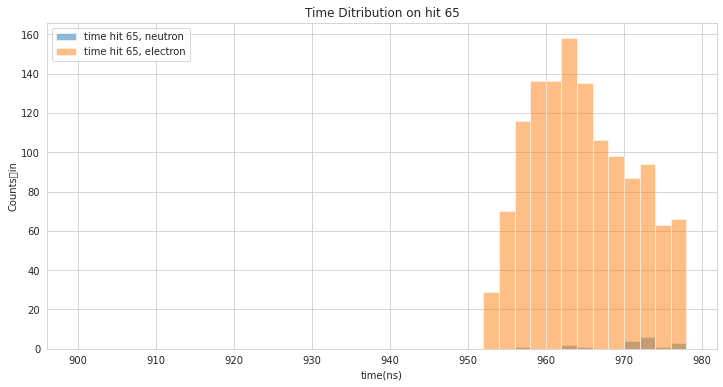

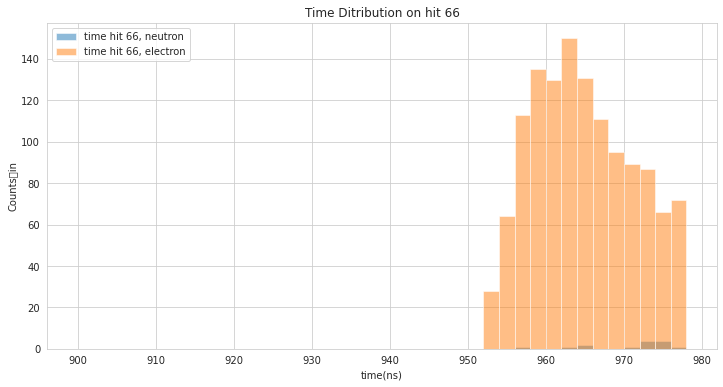

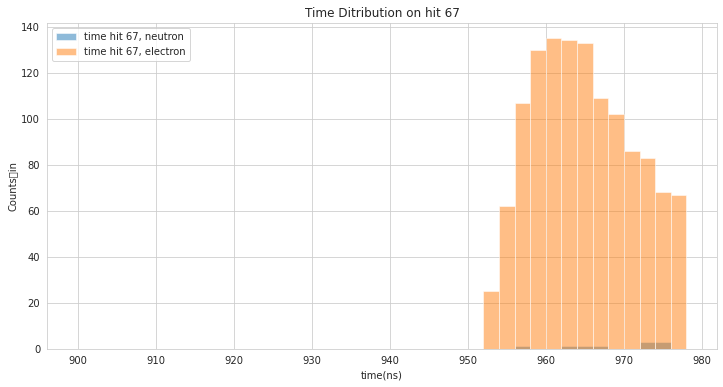

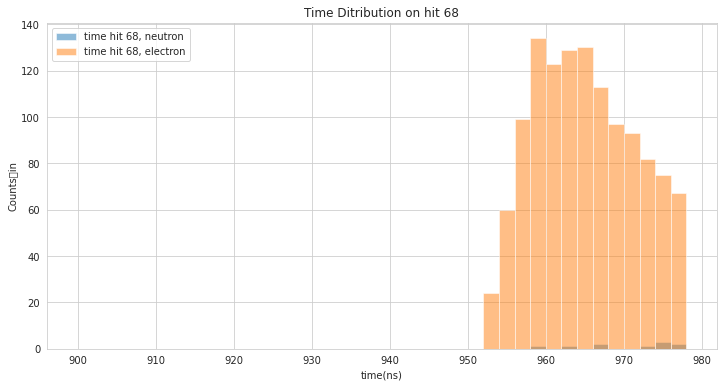

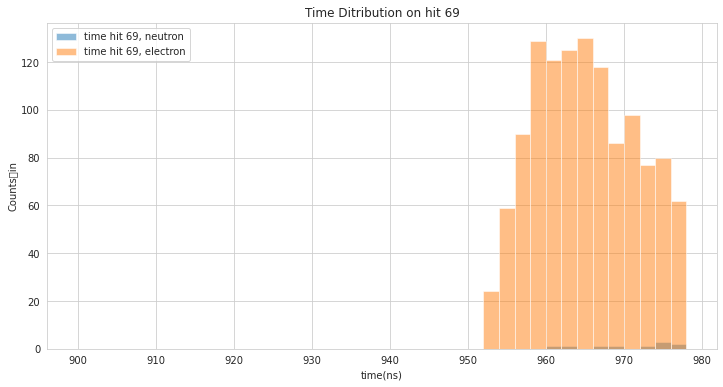

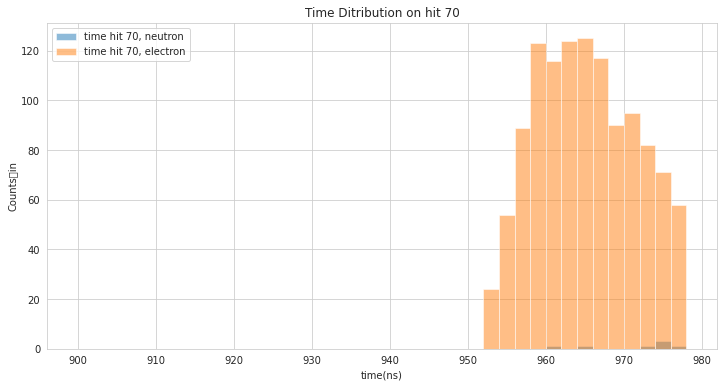

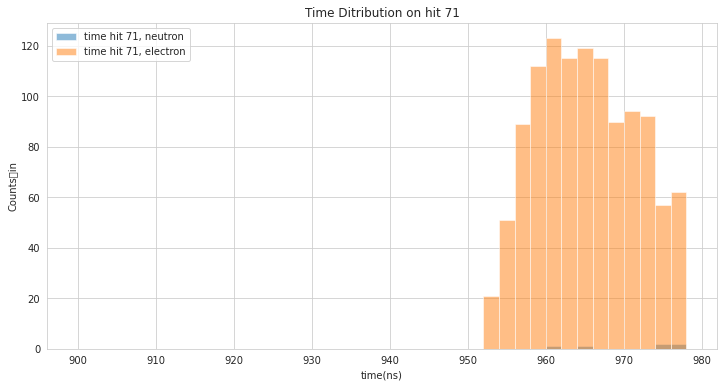

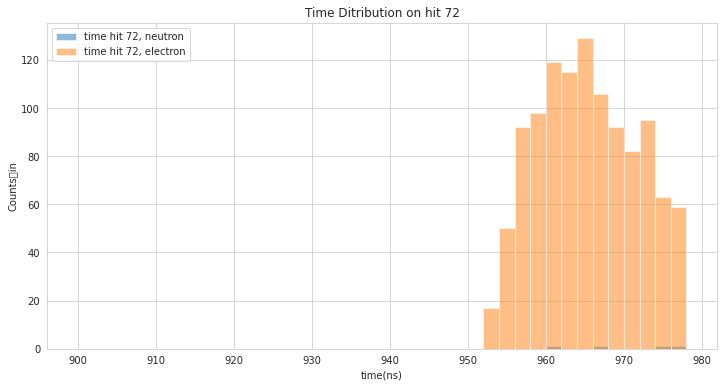

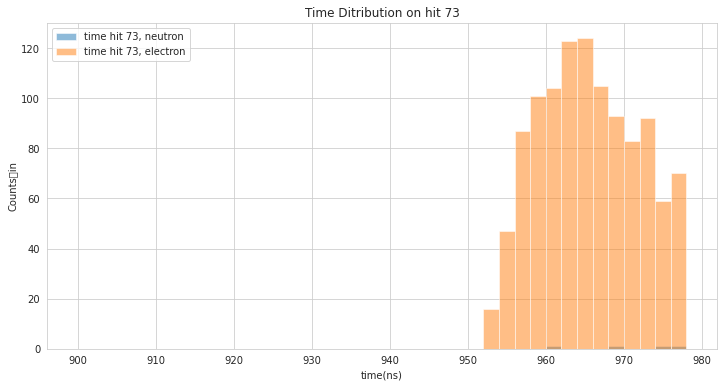

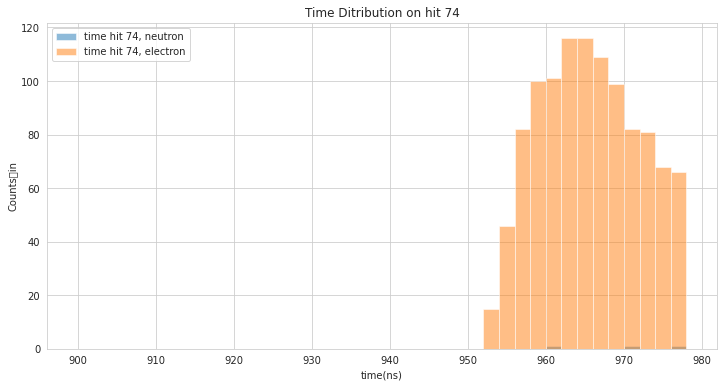

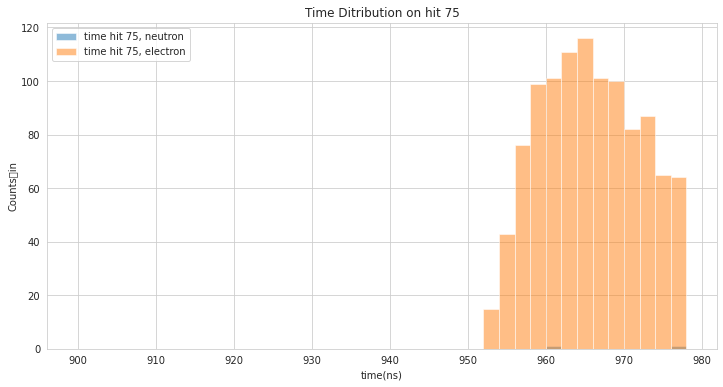

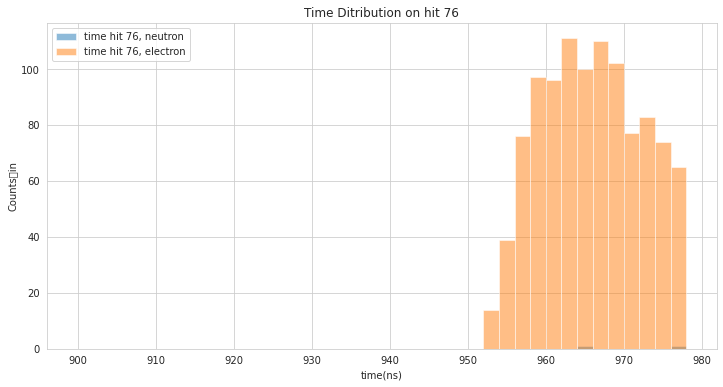

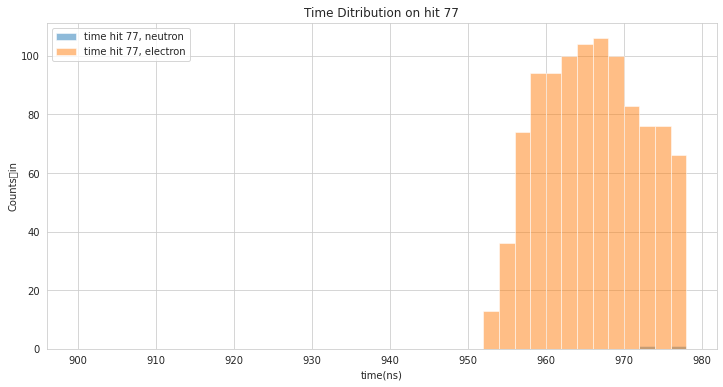

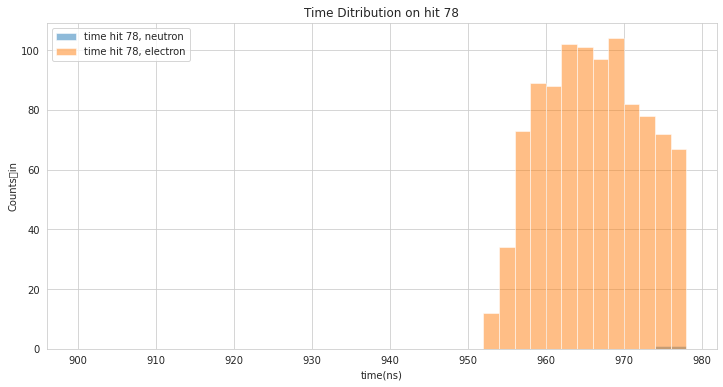

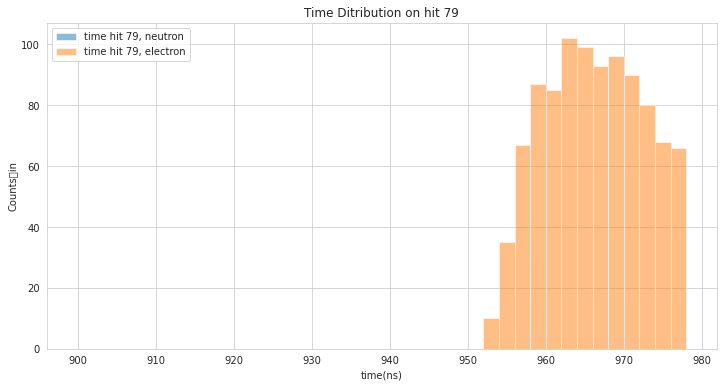

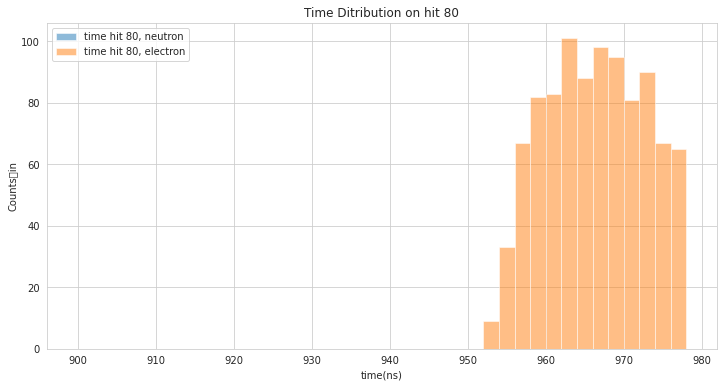

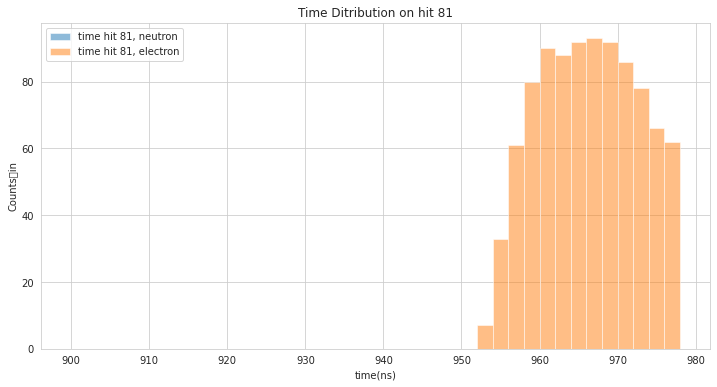

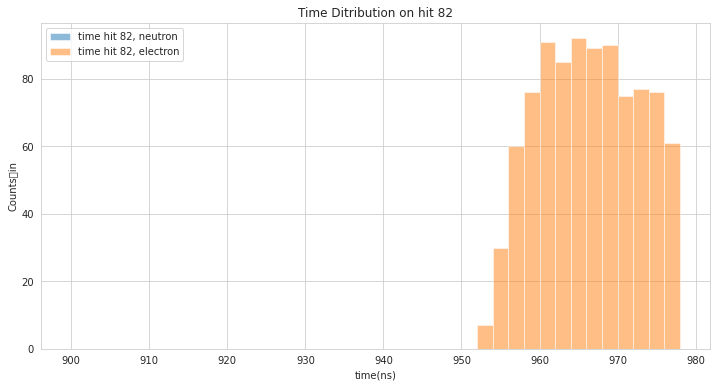

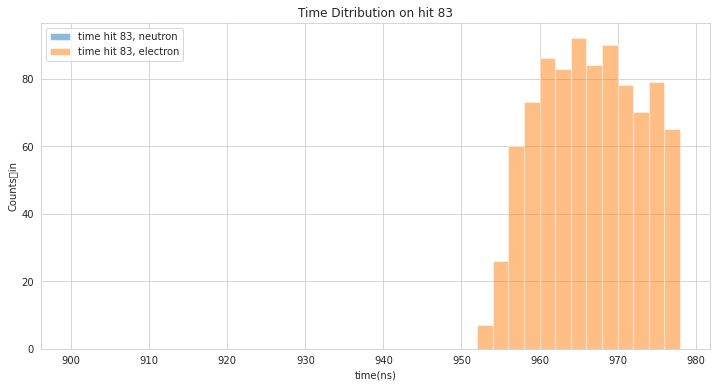

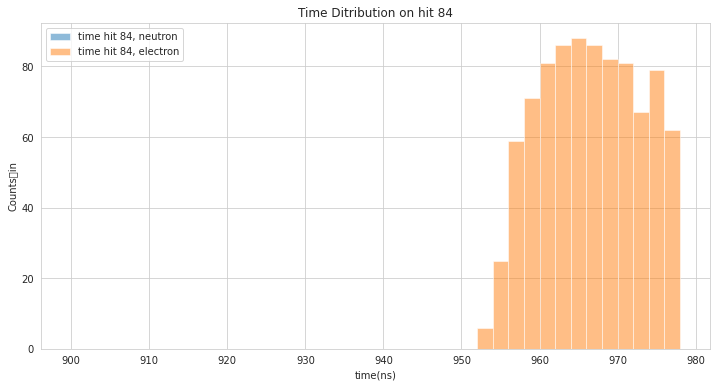

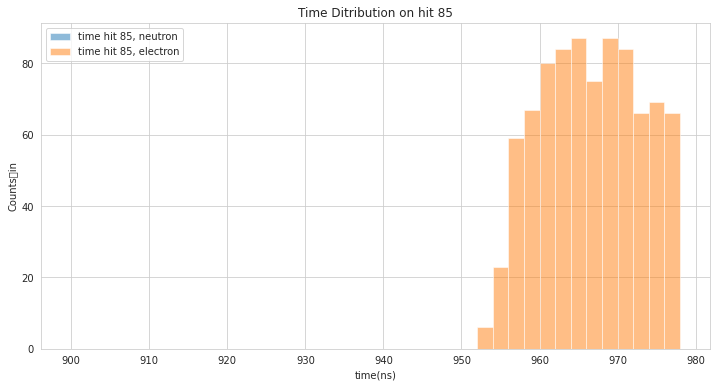

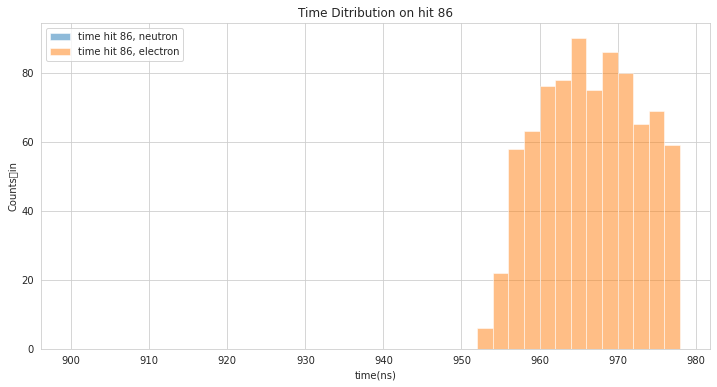

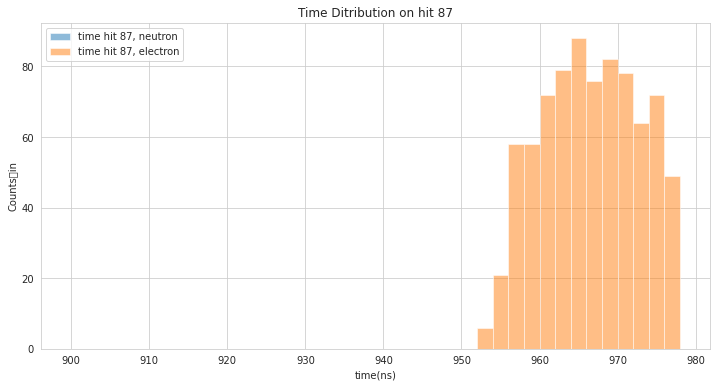

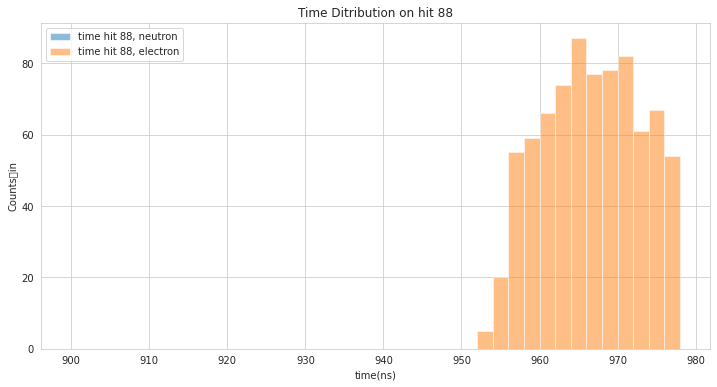

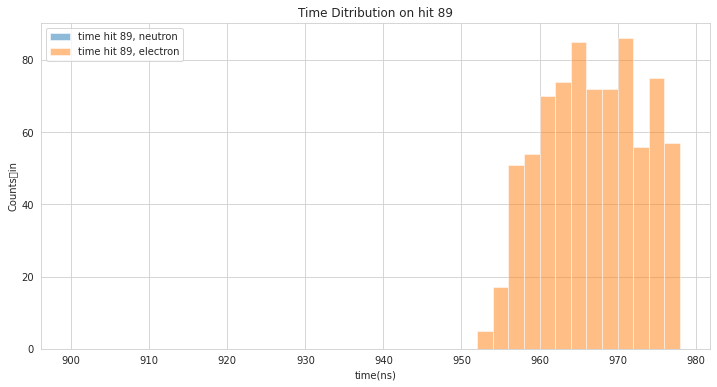

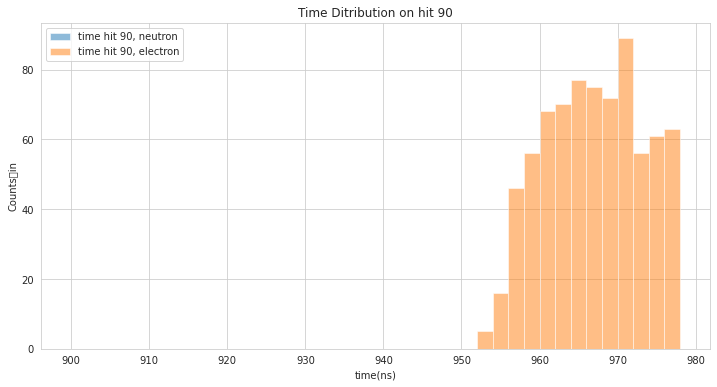

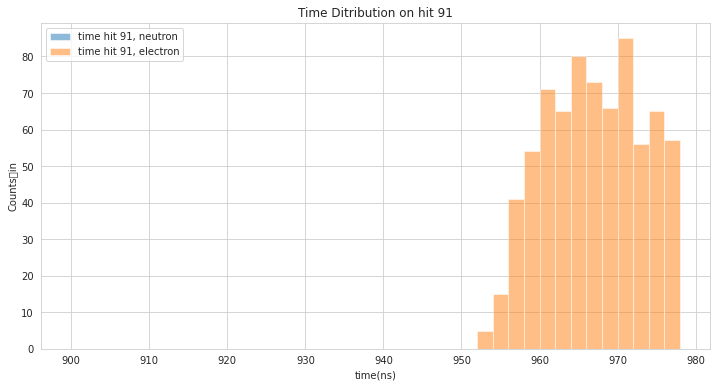

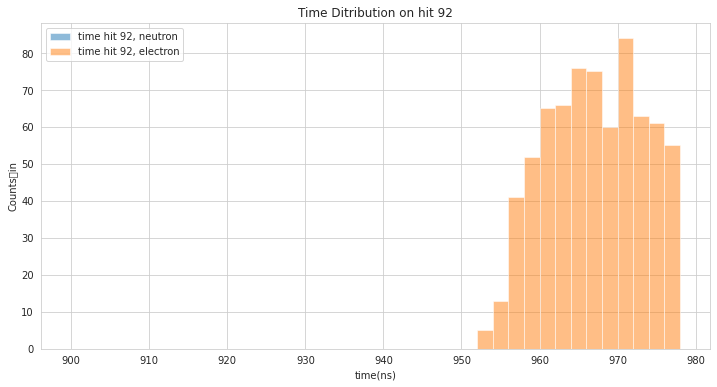

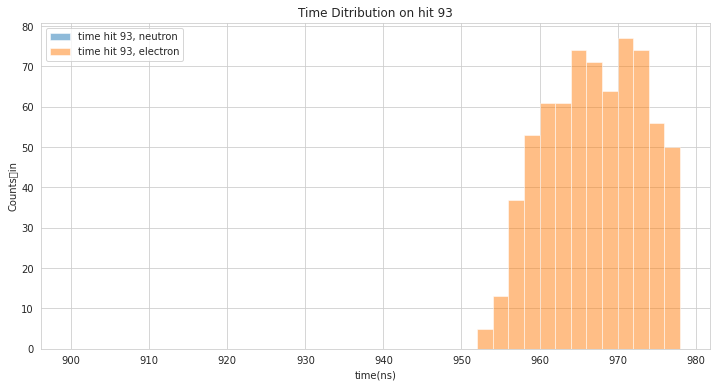

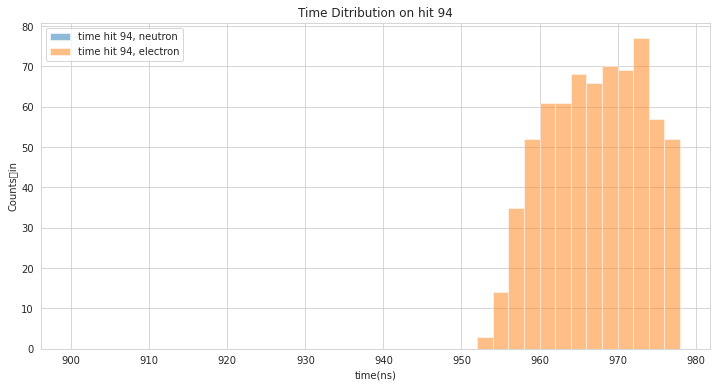

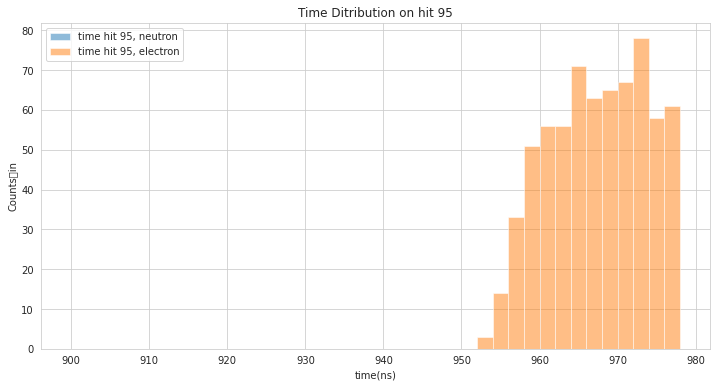

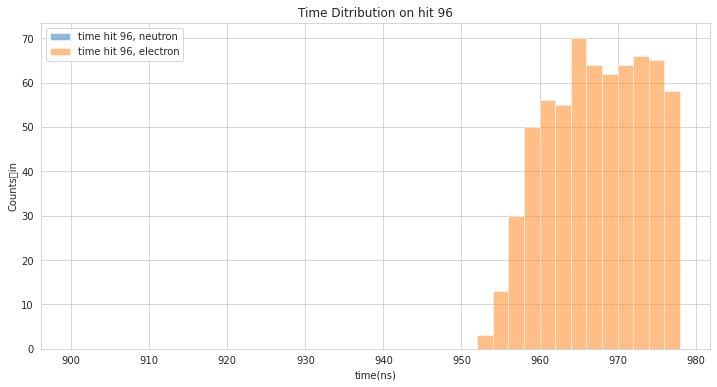

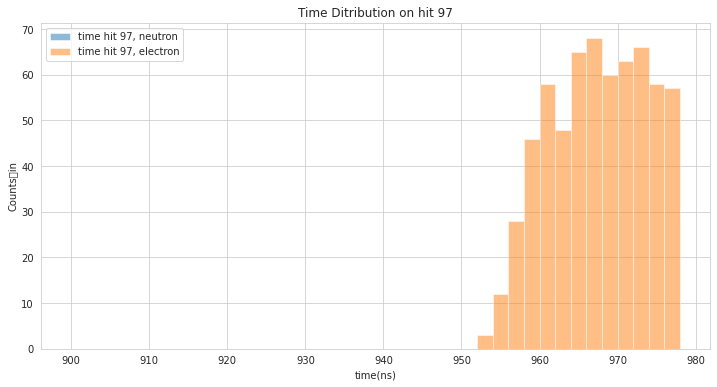

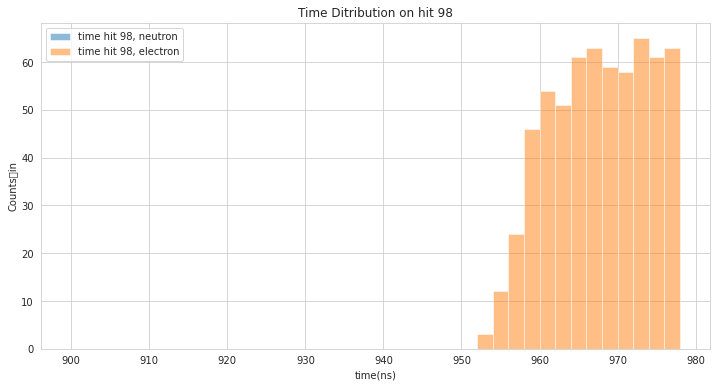

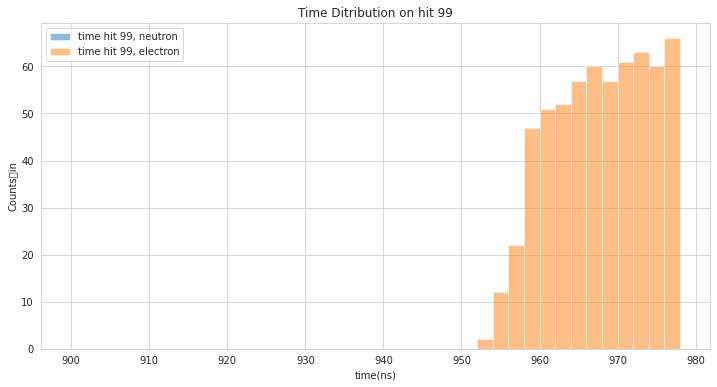

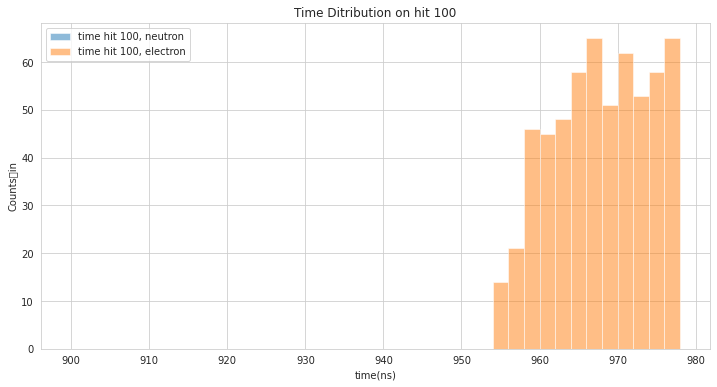

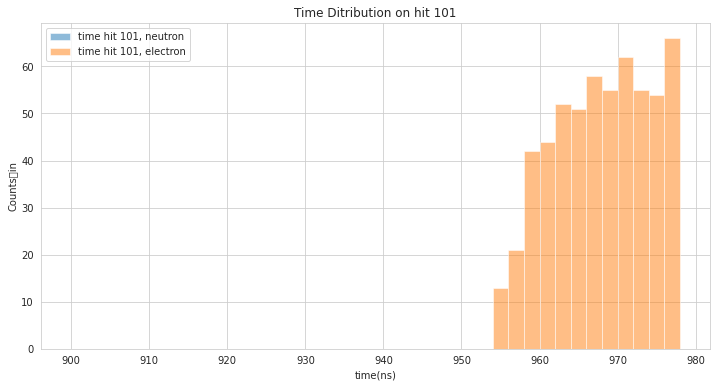

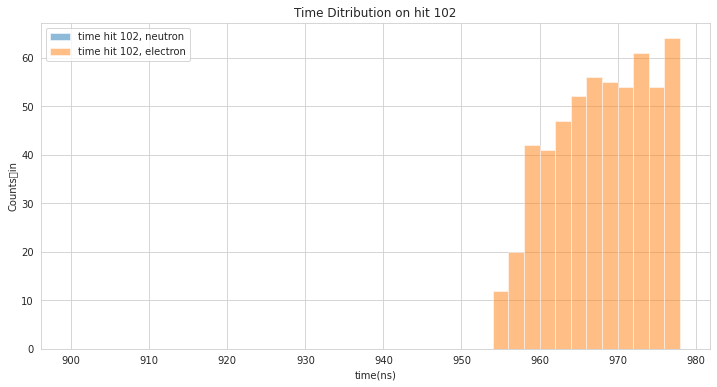

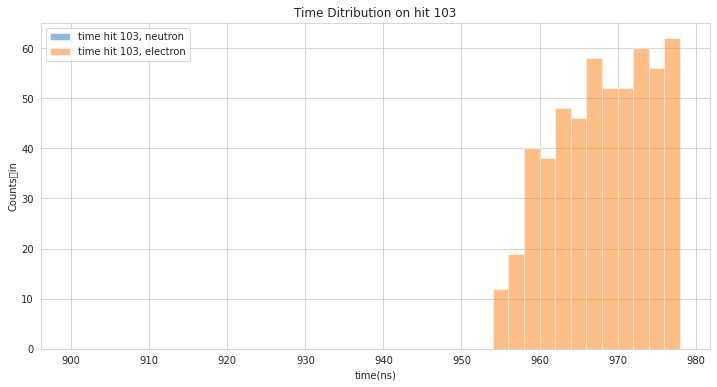

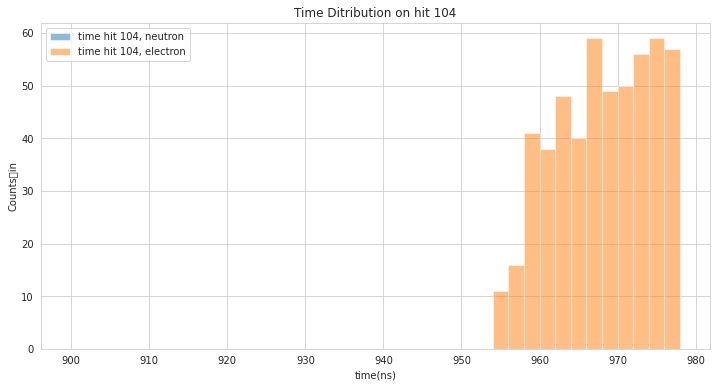

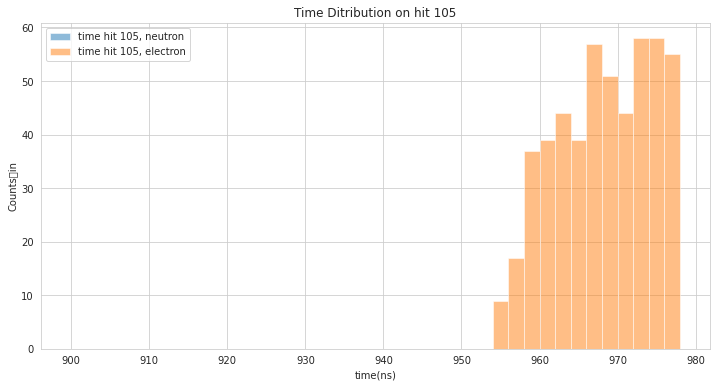

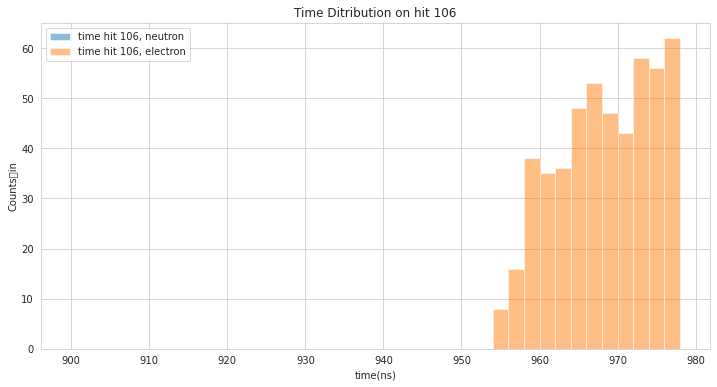

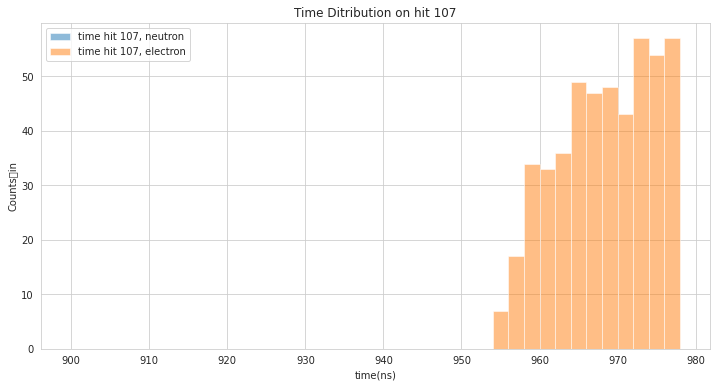

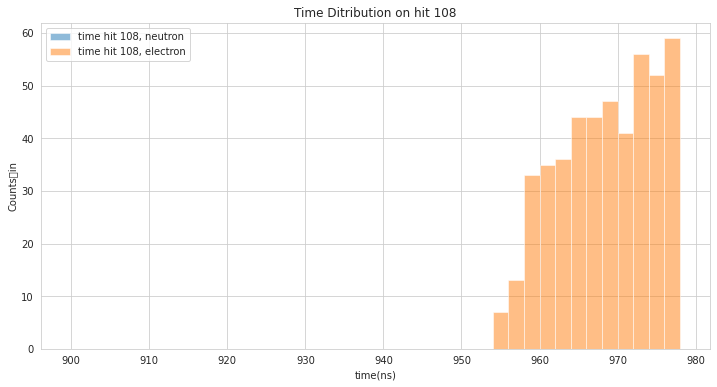

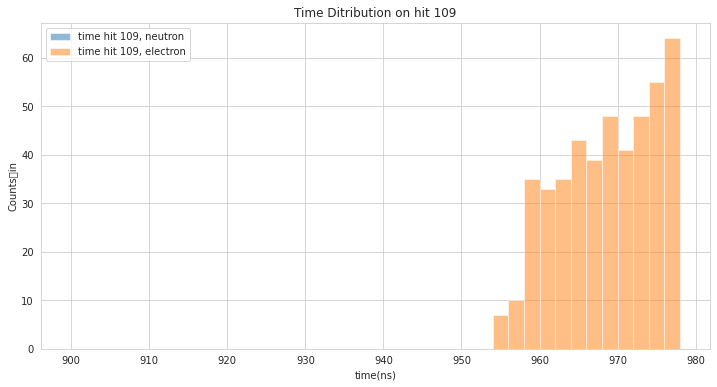

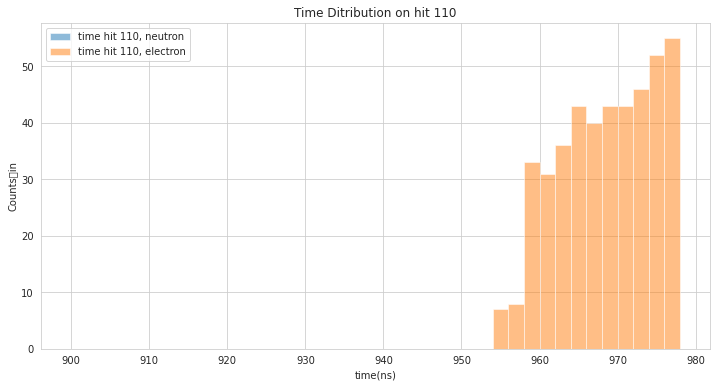

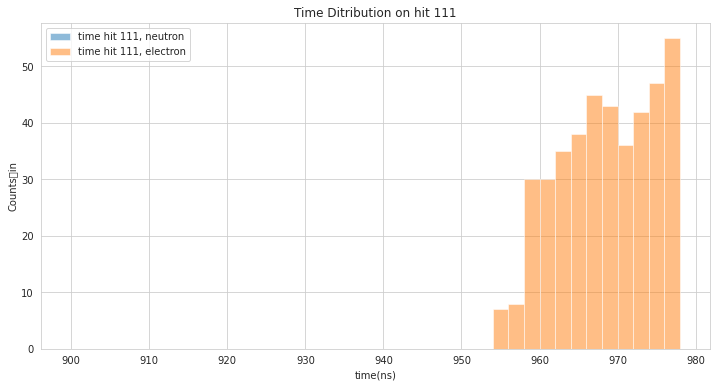

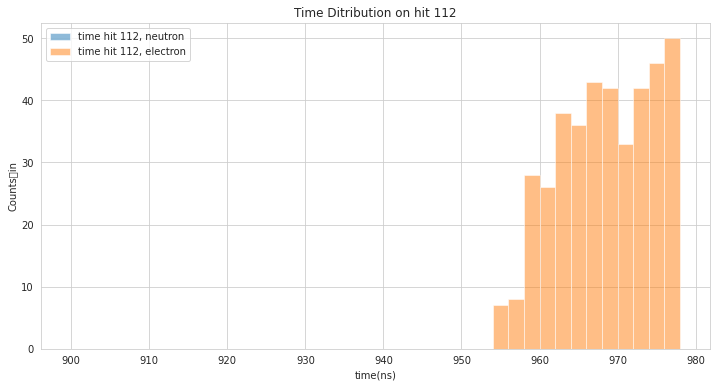

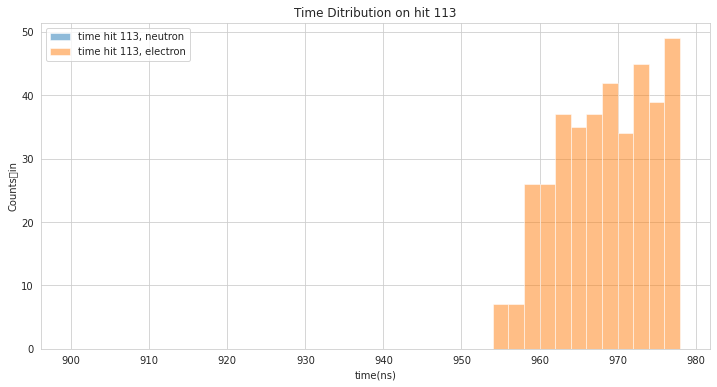

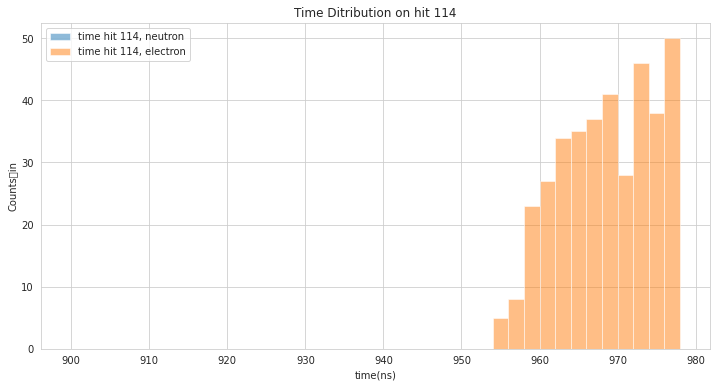

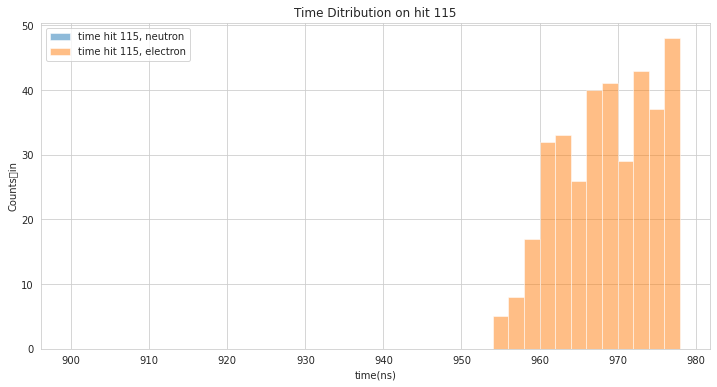

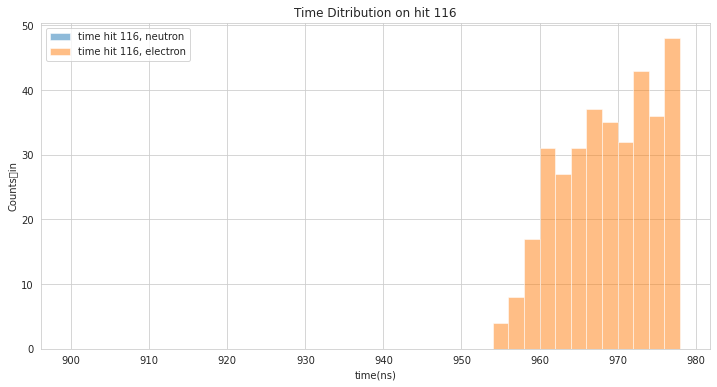

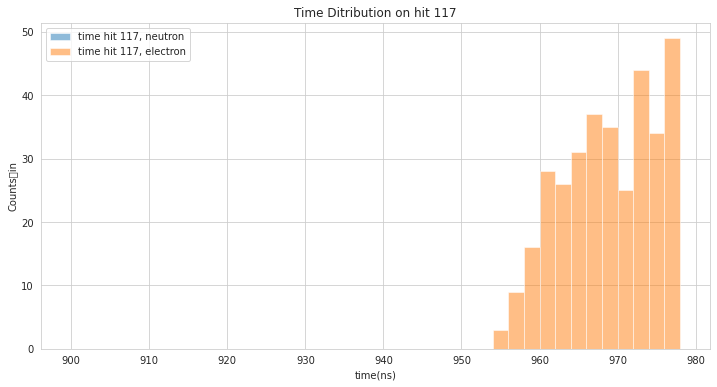

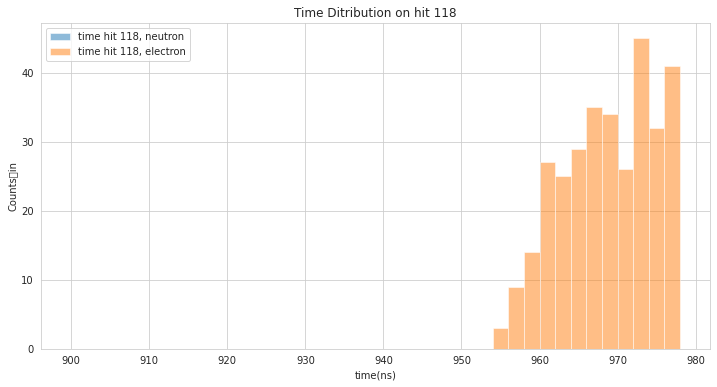

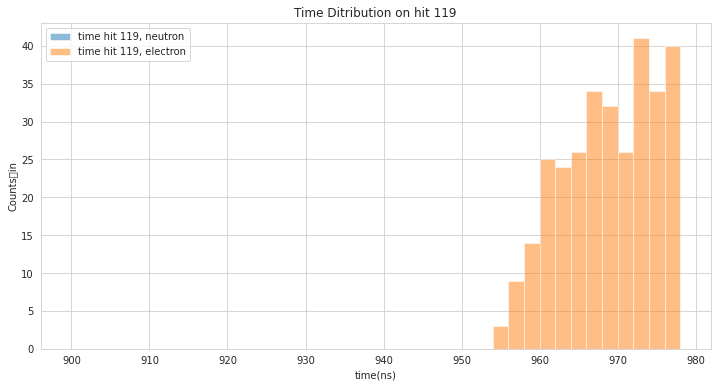

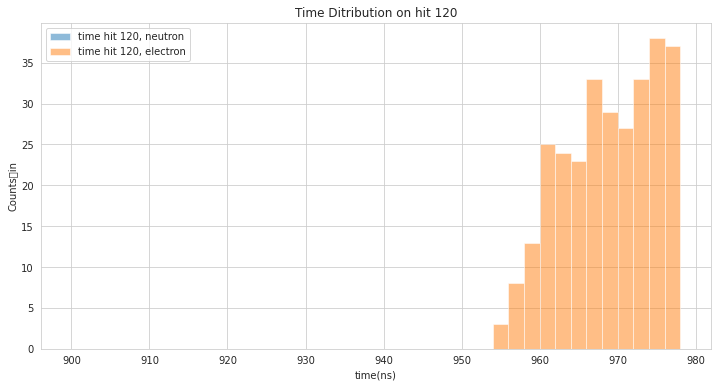

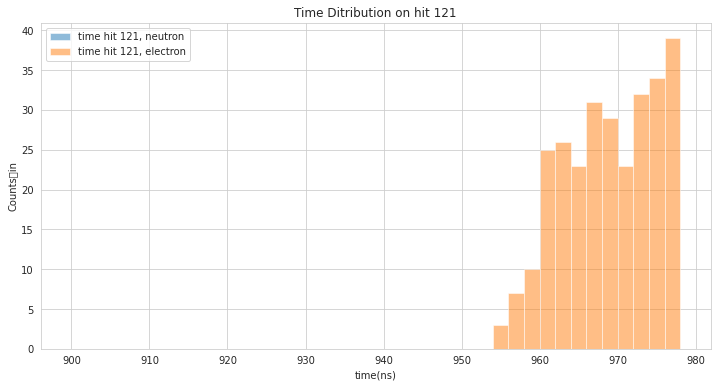

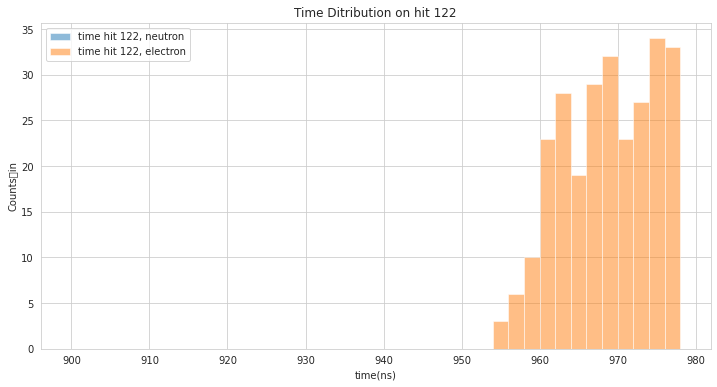

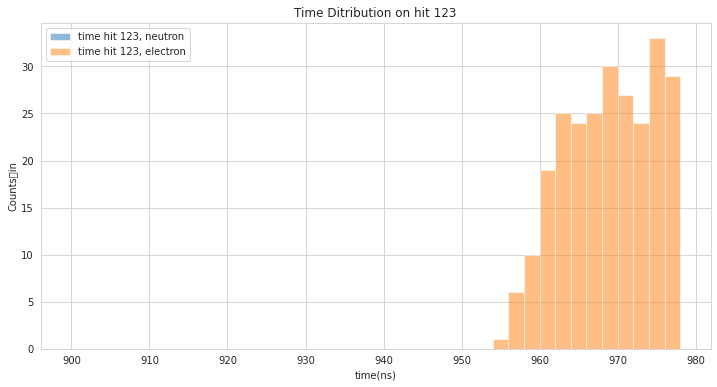

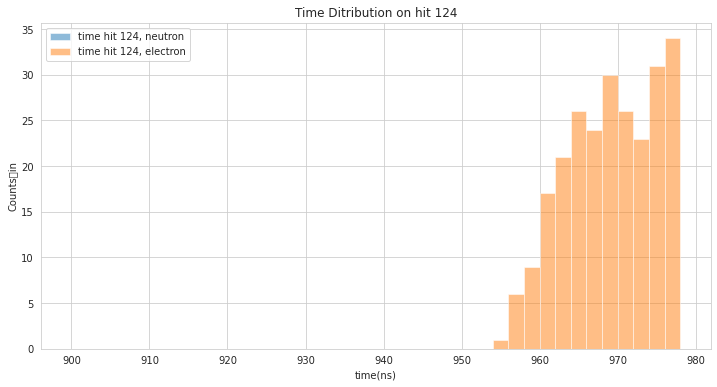

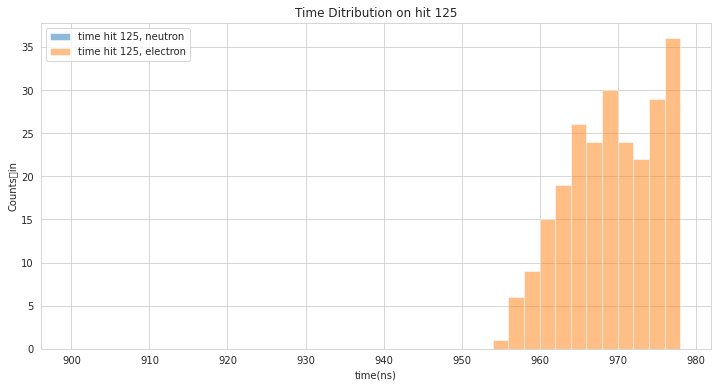

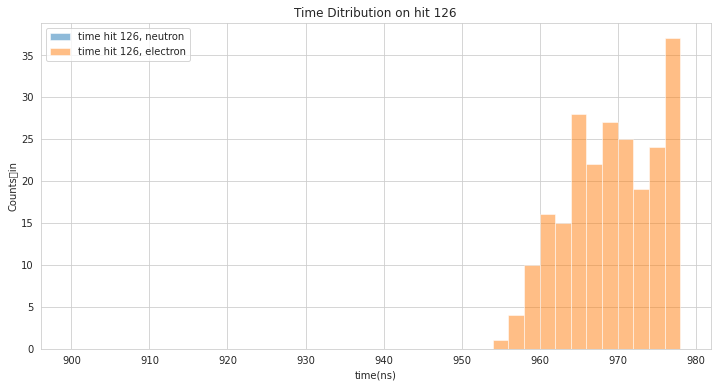

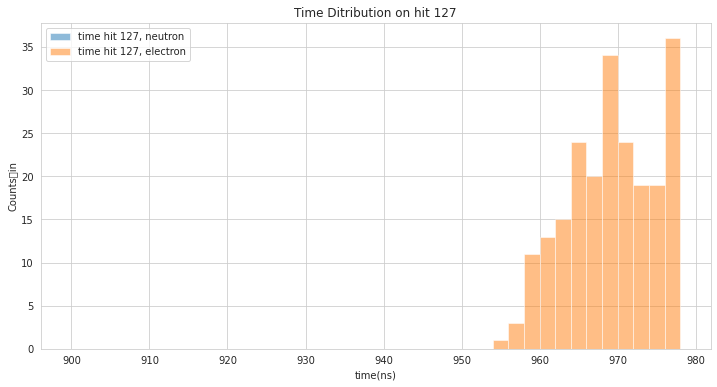

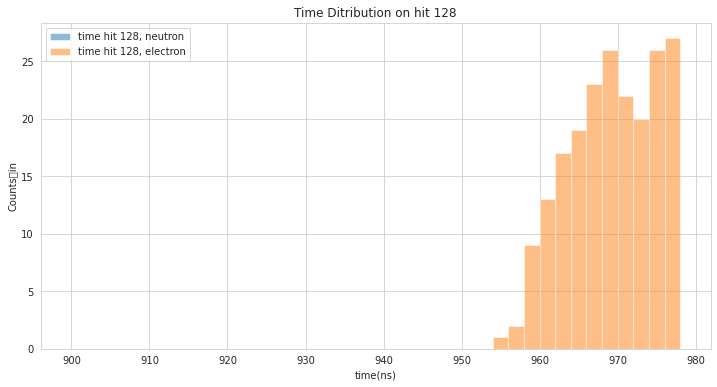

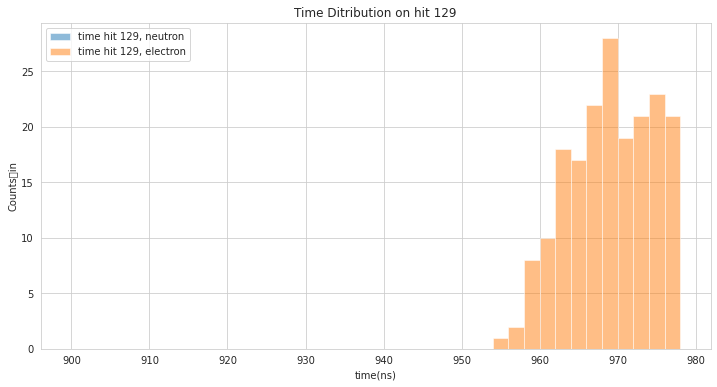

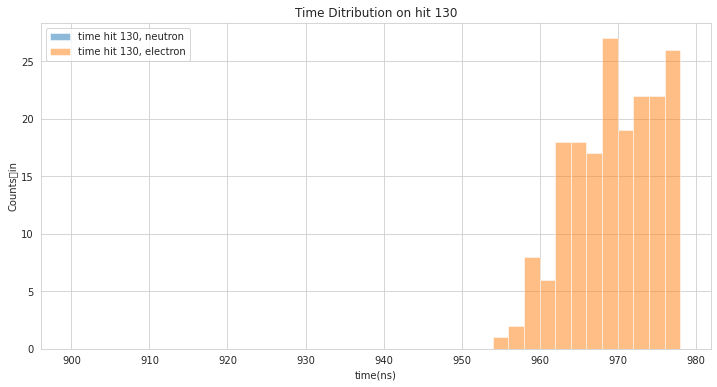

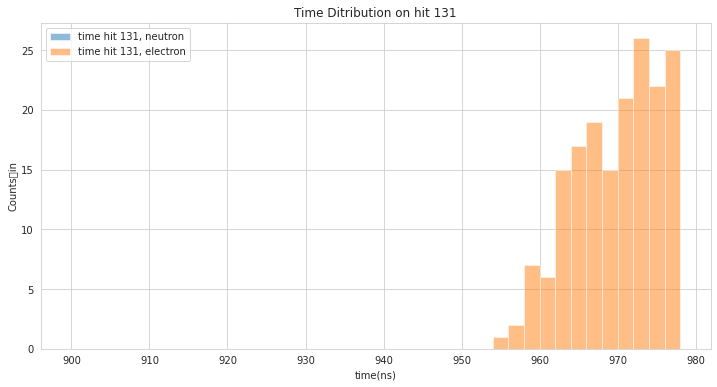

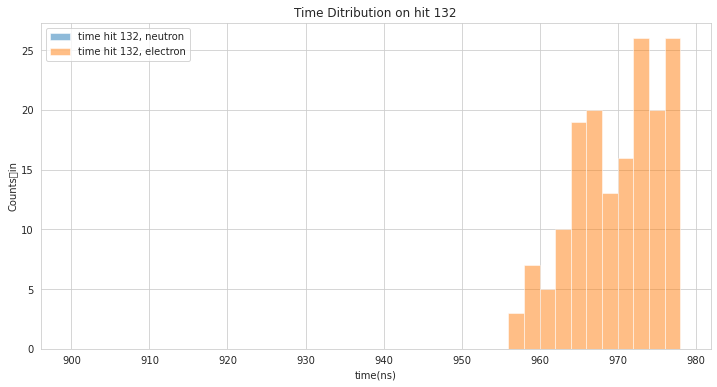

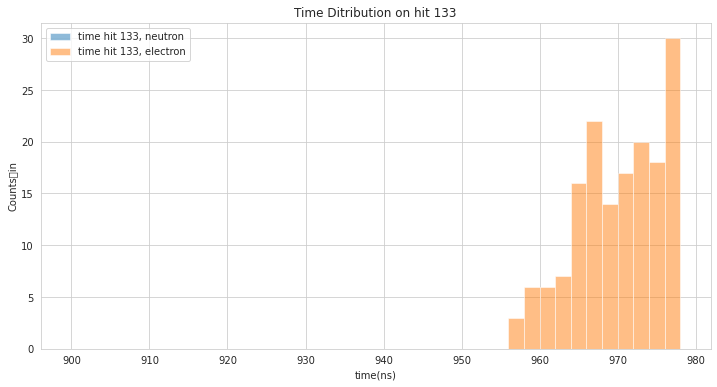

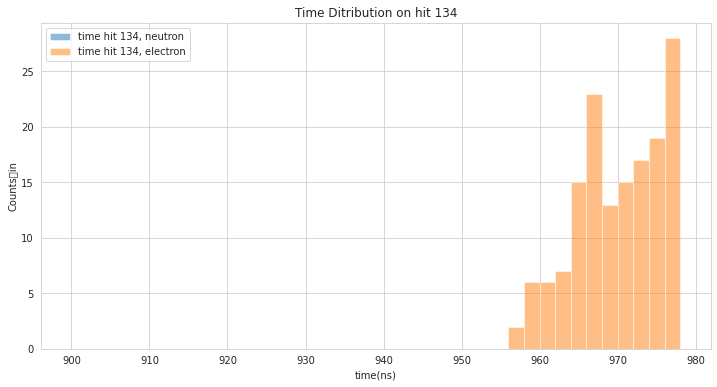

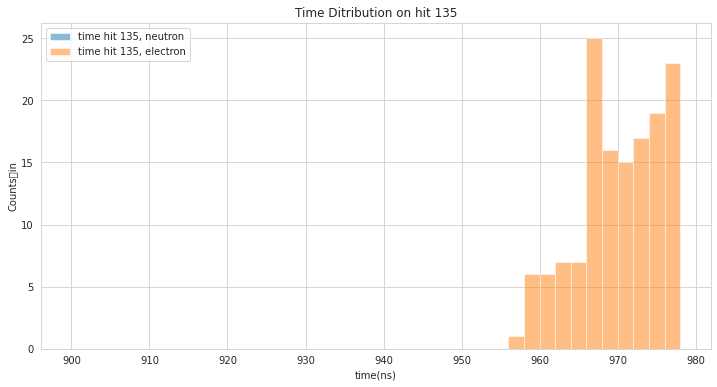

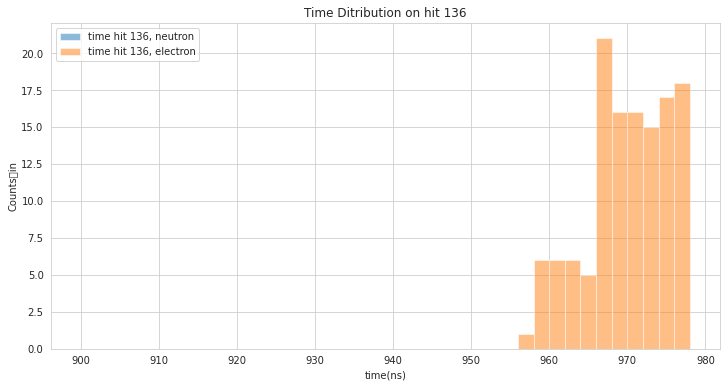

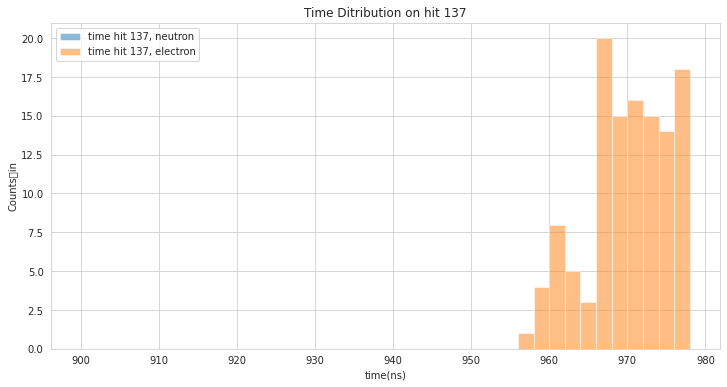

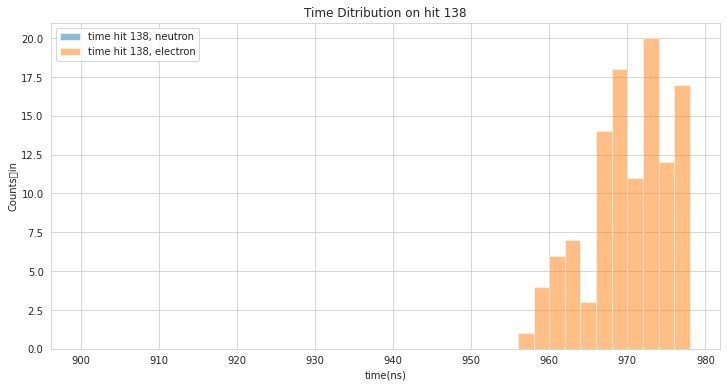

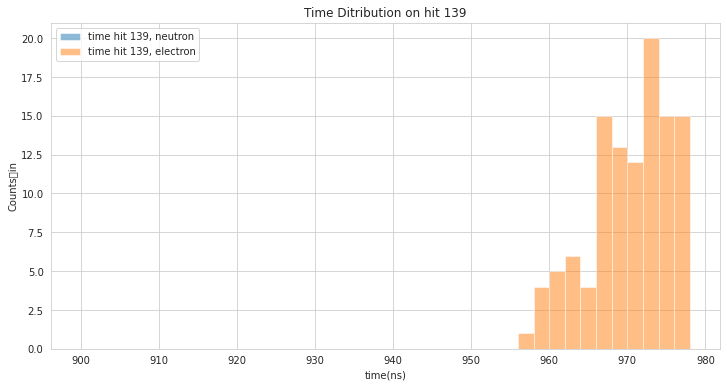

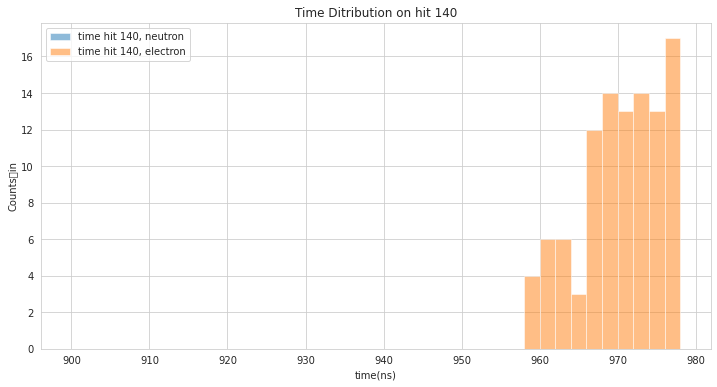

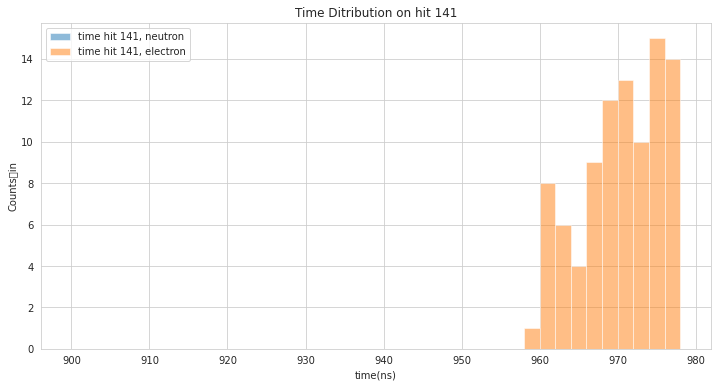

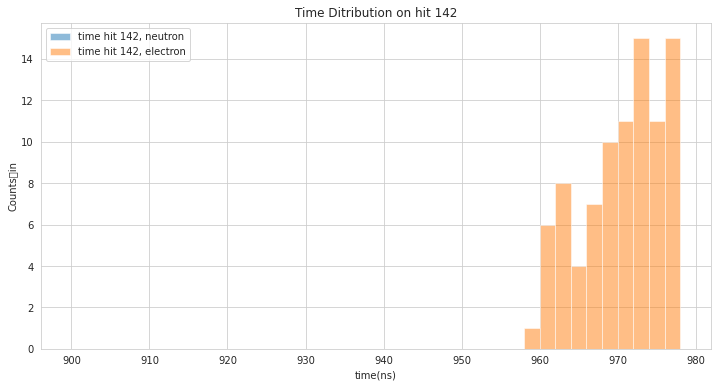

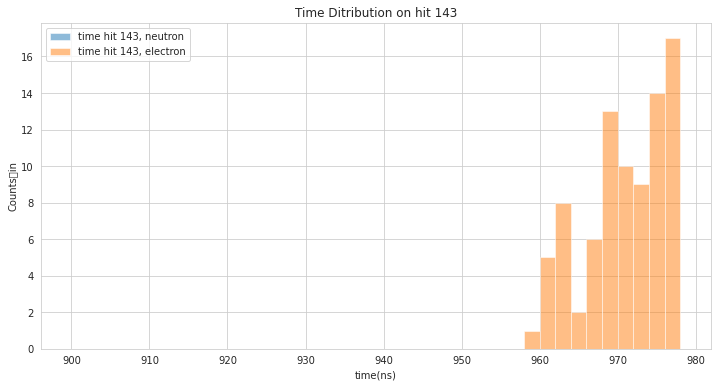

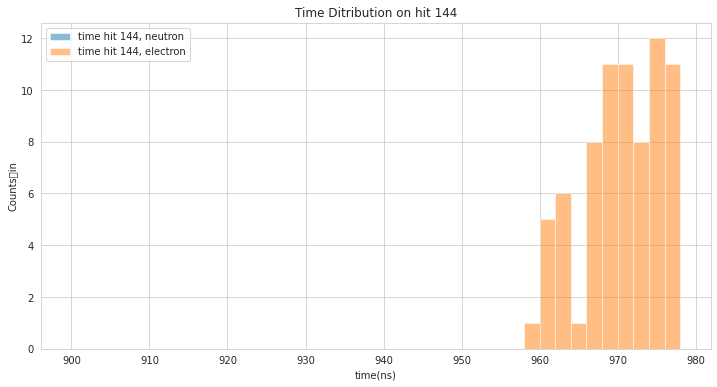

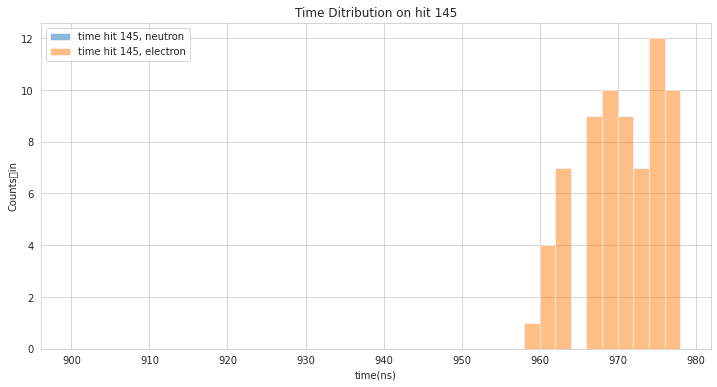

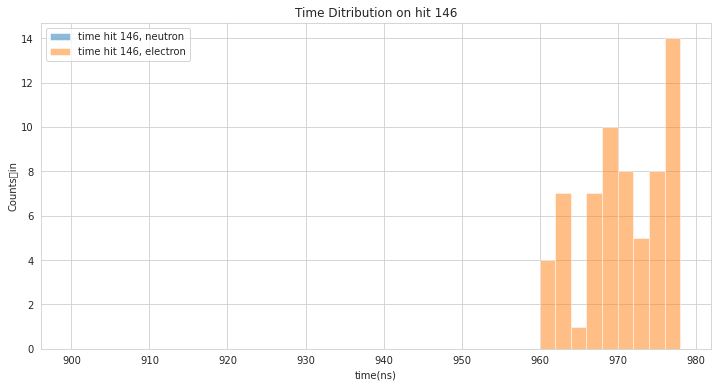

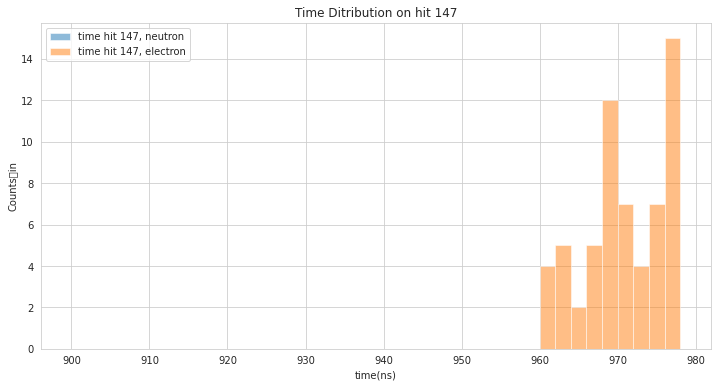

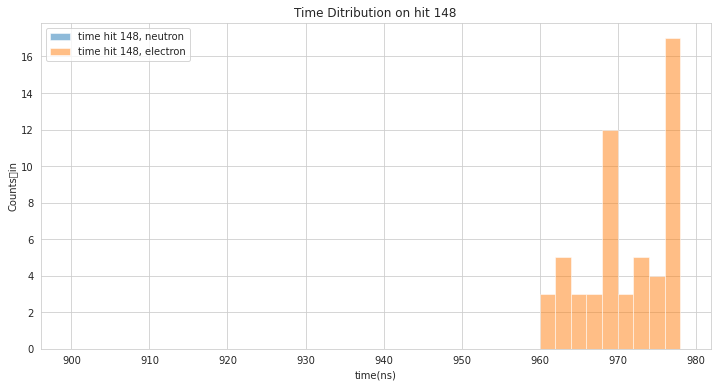

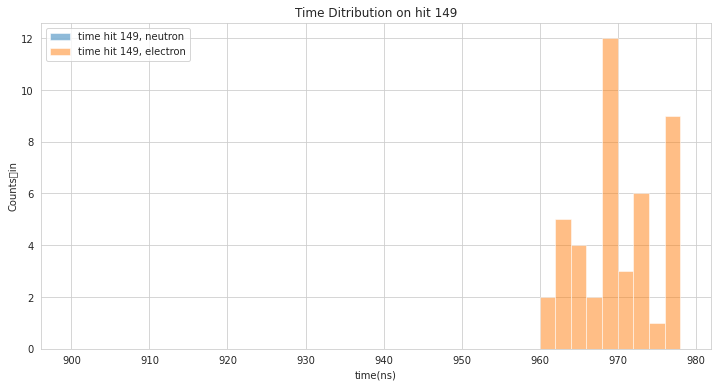

In [86]:
for i in range(150):
    plot_timing(i)
   # plt.savefig("/home/mattStubbs/watchmal/NeutronGNN/data/dump/timing_hits/timing_hit" + str(i))